# Regression analysis with Python: `statsmodels`, `bambi`, `pymc3`, and `arviz`

This workshop's goal&mdash;which is facilitated by this Jupyter notebook&mdash;is to give attendees the confidence to conduct regression analyses with `python` for their research projects.

[statsmodels](https://www.statsmodels.org/stable/index.html) is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration

[bambi](https://bambinos.github.io/bambi/main/index.html) is a high-level Bayesian model-building interface written in Python

[pymc3](https://docs.pymc.io/en/v3/) allows you to write down Bayesian models using an intuitive syntax to describe a data generating process

[arviz](https://arviz-devs.github.io/arviz/index.html) is a Python package for exploratory analysis of Bayesian models

To motivate this workshop, we'll work with examples from [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/examples.html), as well as a few other examples, and go through the various steps of conducting regression analyses in both [classical](https://www.statsmodels.org/stable/regression.html) and [Bayesian](https://bambinos.github.io/bambi/main/notebooks/getting_started.html) frameworks.  Hopefully, you will come away feeling confident you can use `python` to conduct regression analyses for your research projects.

## Table of Contents

1. Linear regression with `statsmodels`

  - A binary predictor
  - A continuous predictor
  - Two predictors (no interaction)
  - Two predictors (with interaction)
  - Categorical predictor (indicator variables)
  - Transformations (e.g. square root, natural log, other powers)

2. Linear regression with `bambi`

  - A binary predictor
  - A continuous predictor
  - Two predictors (no interaction)
  - Two predictors (with interaction)
  - Model comparison

3. Linear regression with `pymc3`

  - Two predictors (with interaction)

## Install specific packages

In [ ]:
!pip install bambi

In [ ]:
!pip install statsmodels==0.13.2

In [ ]:
!pip install pandas==1.3.5

## Load packages

In [168]:
from datetime import datetime

import random
import numpy as np
from numpy.random import default_rng
from numpy.polynomial.polynomial import polyfit
from scipy.special import expit, logit
from scipy.interpolate import interp1d, make_interp_spline, BSpline
import pandas as pd
from pandas.api.types import CategoricalDtype
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

import palettable

import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pymc3 as pm
from pymc3 import glm
import theano

import bambi as bmb

import arviz as az

from IPython.display import HTML
from IPython.display import Markdown as md

import warnings
warnings.filterwarnings('ignore')

md('Analysis last performed on {}.'.format(datetime.today().strftime('%m/%d/%Y')))

Analysis last performed on 05/12/2022.

## Check package versions

In [169]:
pd.__version__

'1.3.5'

In [170]:
sm.__version__

'0.13.2'

In [171]:
bmb.__version__

'0.7.1'

## List pre-defined style sheets provided by [`matplotlib`](https://matplotlib.org/stable/tutorials/introductory/customizing.html#using-style-sheets):

In [172]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'arviz-bluish',
 'arviz-brownish',
 'arviz-colors',
 'arviz-cyanish',
 'arviz-darkgrid',
 'arviz-grayscale',
 'arviz-greenish',
 'arviz-orangish',
 'arviz-plasmish',
 'arviz-purplish',
 'arviz-redish',
 'arviz-royish',
 'arviz-viridish',
 'arviz-white',
 'arviz-whitegrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

# Load Data into DataFrame

The data used in these examples is available in the following [GitHub repository]().  For this example, we're working with the `kidiq` dataset from [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/examples.html).

In [173]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

# Load data into a DataFrame
kidiq = pd.read_csv('https://raw.githubusercontent.com/avehtari/ROS-Examples/master/KidIQ/data/kidiq.csv')
kidiq

kid_score  mom_hs      mom_iq  mom_work  mom_age
0           65       1  121.117529         4       27
1           98       1   89.361882         4       25
2           85       1  115.443165         4       27
3           83       1   99.449639         3       25
4          115       1   92.745710         4       27
..         ...     ...         ...       ...      ...
429         94       0   84.877412         4       21
430         76       1   92.990392         4       23
431         50       0   94.859708         2       24
432         88       1   96.856624         2       21
433         70       1   91.253336         2       25

[434 rows x 5 columns]

In [174]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html

# Check for missing values
kidiq.isna().sum()

kid_score    0
mom_hs       0
mom_iq       0
mom_work     0
mom_age      0
dtype: int64

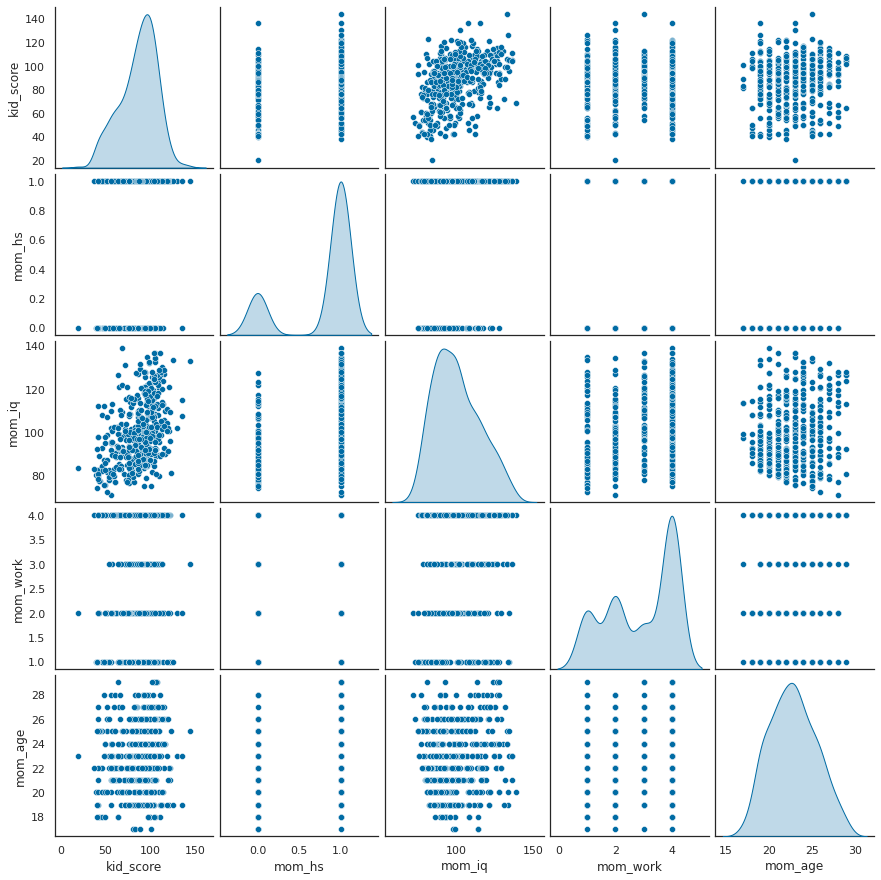

In [94]:
# SOURCE: https://seaborn.pydata.org/generated/seaborn.pairplot.html

# Review the joint distribution of the variables in the dataset
sns.pairplot(kidiq, diag_kind='kde');

In [95]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

# Review the summary statistics for the variables in the dataset
kidiq.describe().round(decimals=2)  # transpose().round(decimals=1)

kid_score  mom_hs  mom_iq  mom_work  mom_age
count     434.00  434.00  434.00    434.00   434.00
mean       86.80    0.79  100.00      2.90    22.79
std        20.41    0.41   15.00      1.18     2.70
min        20.00    0.00   71.04      1.00    17.00
25%        74.00    1.00   88.66      2.00    21.00
50%        90.00    1.00   97.92      3.00    23.00
75%       102.00    1.00  110.27      4.00    25.00
max       144.00    1.00  138.89      4.00    29.00

In [96]:
# SOURCE: https://www.statsmodels.org/stable/generated/statsmodels.stats.descriptivestats.describe.html

# Review the summary statistics for the variables in the dataset
print(sm.stats.Describe(kidiq.values).summary(stats='all'))

                   Summary Statistics                   
           Col 0    Col 1     Col 2    Col 3     Col 4  
--------------------------------------------------------
obs          434.0    434.0     434.0    434.0     434.0
mean         86.80   0.7857     100.0    2.896     22.79
std          20.39   0.4103     14.98    1.180     2.698
min          20.00    0.000     71.04    1.000     17.00
max          144.0    1.000     138.9    4.000     29.00
ptp          124.0    1.000     67.86    3.000     12.00
var          415.6   0.1684     224.5    1.392     7.279
mode_val     94.00    1.000     97.60    4.000     23.00
mode_bin     18.00    341.0     4.000    205.0     63.00
median       90.00    1.000     97.92    3.000     23.00
uss      3.450e+06    341.0 4.437e+06    4245. 2.285e+05
skew       -0.4606   -1.393    0.4668  -0.4467    0.1765
kurtosis   -0.1724 -0.06061   -0.5779   -1.382   -0.6398
perc_01      41.00    0.000     75.02    1.000     18.00
perc_05      49.00    0.000    

## Exercise: Refer to the [seaborn documentation](https://seaborn.pydata.org/tutorial.html) and create some additional distribution plots for the variables in the dataset.

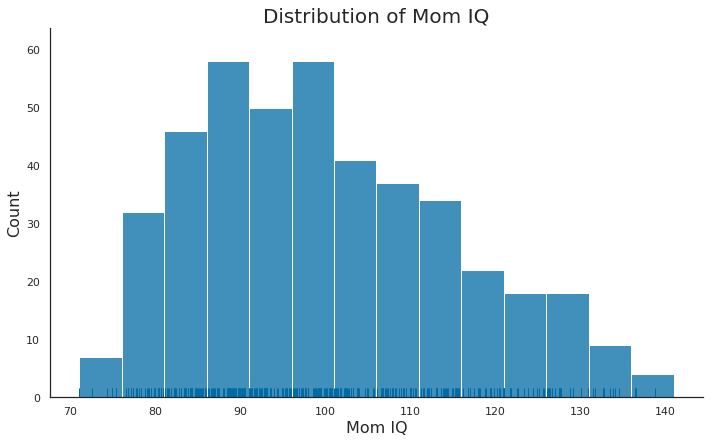

In [97]:
# For example:
sns.displot(kidiq, x='mom_iq', rug=True, binwidth=5, height=6, aspect=10/6)
plt.xlabel('Mom IQ', fontsize=16);
plt.ylabel('Count', fontsize=16);
plt.title('Distribution of Mom IQ', fontsize=20);

In [98]:
# Your turn: Create a distribution plot for a variable in the kidiq dataset using seaborn



In [99]:
# Your turn: Create a distribution plot for a variable in the kidiq dataset using seaborn



## Exercise: Refer to the [plotly documentation](https://plotly.com/python/) and create some additional distribution plots for the variables in the dataset.

In [100]:
# For example:
p1 = px.histogram(kidiq, x='mom_iq',
                  labels=dict(mom_iq='Mom IQ', count='Count'),
                  #title='Distribution of Mom IQ',
                  height=500, width=800)

p1.update_layout(
    title={
        'text': 'Distribution of Mom IQ',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'auto'},
        bargap=0.15)
p1.update_yaxes(title_text='Count')

p1.show();

In [101]:
# Your turn: Create a distribution plot for a variable in the kidiq dataset using plotly



In [102]:
# Your turn: Create a distribution plot for a variable in the kidiq dataset using plotly



# statsmodels (R-style formula interface)

## A single predictor

We start by modeling the children's test scores with an intercept (a column of 1s), which summarizes the children's overall mean test score.  As shown by the coefficient for the Intercept, the children's overall mean test score is about 87.

In [103]:
# SOURCE: https://www.statsmodels.org/stable/example_formulas.html

# Fit regression model
fit0 = smf.ols('kid_score ~ 1', data=kidiq).fit()

# Inspect results
print(fit0.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 12 May 2022   Prob (F-statistic):                nan
Time:                        15:48:02   Log-Likelihood:                -1924.3
No. Observations:                 434   AIC:                             3851.
Df Residuals:                     433   BIC:                             3855.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     86.7972      0.980     88.592      0.0

In [104]:
# Inspect results
print(fit0.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.000    
Dependent Variable: kid_score        AIC:                3850.5765
Date:               2022-05-12 15:48 BIC:                3854.6495
No. Observations:   434              Log-Likelihood:     -1924.3  
Df Model:           0                F-statistic:        nan      
Df Residuals:       433              Prob (F-statistic): nan      
R-squared:          0.000            Scale:              416.60   
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept      86.7972    0.9797  88.5917  0.0000  84.8716  88.7229
------------------------------------------------------------------
Omnibus:               14.895       Durbin-Watson:          1.477 
Prob(Omnibus):         0.001        Jarque-Bera (JB):       15.881
Skew:    

Let's double-check that the result of regressing children's test scores on an intercept does indeed produce the mean of the children's test scores.

In [105]:
# Average kid_score in the dataset
np.round(kidiq['kid_score'].mean(), decimals=4)

86.7972

The `fit0` object has many useful attributes.  Type `dir(fit0)` for a full list of attributes.

Let's see how we can extract specific pieces of information from the fitted model object.  Here, we extract the log-likelihood and Akaike information criterion (AIC) values for the model.

In [106]:
# Log-Likelihood and Akaike information criterion (AIC)
( np.round(fit0.llf, decimals=1) , np.round(fit0.aic, decimals=1) )

(-1924.3, 3850.6)

### A single binary predictor

Now let's model the children's test scores given an indicator for whether the mother graduated from high school (coded as 1) or not (coded as 0).

We fit the model using `statsmodels`, which allows users to fit statistical models using `R`-style formulas.  Internally, `statsmodels` uses the `patsy` package to convert formulas and data to the matrices that are used in model fitting.

This model summarizes the difference in average test scores between the children of mothers who completed high school and those with mothers who did not.

In [107]:
# SOURCE: https://www.statsmodels.org/stable/example_formulas.html

# Fit regression model
fit1 = smf.ols('kid_score ~ 1 + mom_hs', data=kidiq).fit()

# Inspect results
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     25.69
Date:                Thu, 12 May 2022   Prob (F-statistic):           5.96e-07
Time:                        15:48:02   Log-Likelihood:                -1911.8
No. Observations:                 434   AIC:                             3828.
Df Residuals:                     432   BIC:                             3836.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     77.5484      2.059     37.670      0.0

The `fit1` object has many useful attributes.  Type `dir(fit1)` for a full list of attributes.

In [108]:
dir(fit1)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_is_nested',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'info_c

In [109]:
# Inspect results (version 2)
print(fit1.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.054    
Dependent Variable: kid_score        AIC:                3827.5059
Date:               2022-05-12 15:48 BIC:                3835.6520
No. Observations:   434              Log-Likelihood:     -1911.8  
Df Model:           1                F-statistic:        25.69    
Df Residuals:       432              Prob (F-statistic): 5.96e-07 
R-squared:          0.056            Scale:              394.12   
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept      77.5484    2.0586  37.6702  0.0000  73.5022  81.5945
mom_hs         11.7713    2.3224   5.0685  0.0000   7.2066  16.3359
------------------------------------------------------------------
Omnibus:               11.077       Durbin-Watson:          1.464 
Prob(Omn

The `fit1` object has many useful attributes.  For example, we can extract parameter estimates and fitted values by typing:

In [110]:
fit1.params

Intercept    77.548387
mom_hs       11.771261
dtype: float64

In [111]:
pd.concat([fit1.predict(kidiq['mom_hs']), fit1.fittedvalues], axis=1).rename({0: 'Predicted', 1: 'Fitted'}, axis=1)

Predicted     Fitted
0    89.319648  89.319648
1    89.319648  89.319648
2    89.319648  89.319648
3    89.319648  89.319648
4    89.319648  89.319648
..         ...        ...
429  77.548387  77.548387
430  89.319648  89.319648
431  77.548387  77.548387
432  89.319648  89.319648
433  89.319648  89.319648

[434 rows x 2 columns]

## Regression plots

### `statsmodels` 

[`plot_regress_exog`](https://www.statsmodels.org/stable/graphics.html): Plot regression results against one predictor.  Specifically, plot four graphs in a 2 by 2 figure: 
- `endog versus exog`
- `residuals versus exog`
- `fitted versus exog` 
- `fitted plus residual versus exog`


eval_env: 1


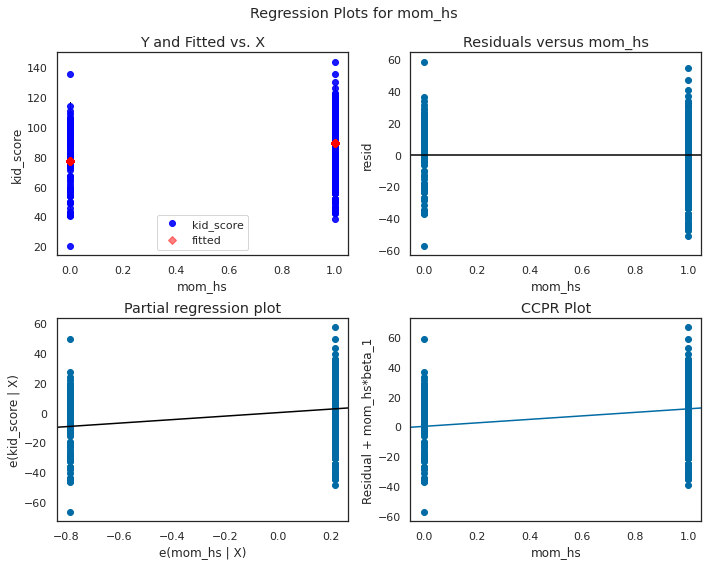

In [112]:
fig = plt.figure(figsize=(10, 8))
sm.graphics.plot_regress_exog(fit1, 'mom_hs', fig=fig);

### `statsmodels`

`abline_plot`: Plot a line given an intercept and slope

Child's test score plotted versus an indicator for wehter mother completed high school.  Superimposed is the regression line, which runs through the average of each subpopulation defined by maternal education level.

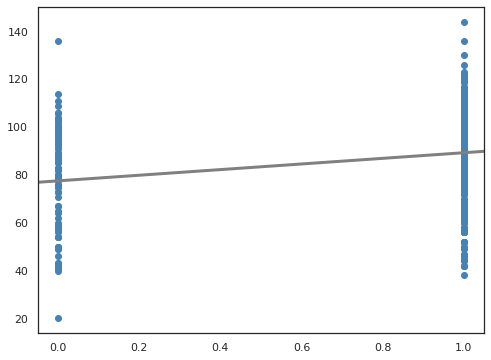

In [113]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(kidiq['mom_hs'], kidiq['kid_score'], facecolors='steelblue', edgecolors=None)
fig = sm.graphics.abline_plot(model_results=fit1, ax=ax, color='gray', linewidth=3)
ax.margins(x=0.1);
#ax.set_xlim(-0.1, 1.1);

### `seaborn` 

[`regplot`](https://seaborn.pydata.org/generated/seaborn.regplot.html): Plot data and a linear regression model fit

Child's test score plotted versus an indicator for wehter mother completed high school.  Superimposed is the regression line, which runs through the average of each subpopulation defined by maternal education level.  The indicator variable for high school completion has been jittered; that is, a random number has been added to each x-value so that the points do not lie on top of each other.

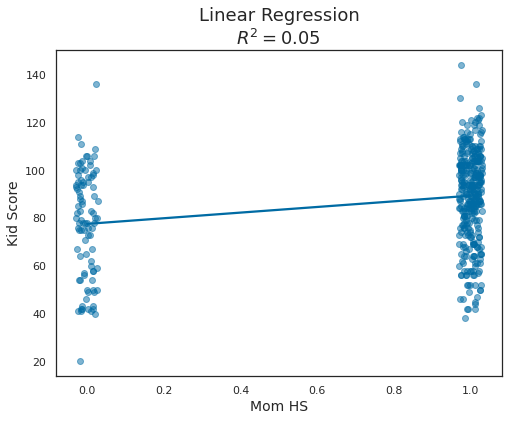

In [114]:
# SOURCE: https://seaborn.pydata.org/generated/seaborn.regplot.html

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.regplot(x='mom_hs',
                 y='kid_score',
                 data=kidiq,
                 fit_reg=True,   # Fit a regression line
                 ci=None,
                 x_jitter=0.03,  # Could also dynamically set this with range of data
                 scatter_kws={'alpha': 0.5}, # Set transparency to 50%
                 ax=ax)
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom HS', fontsize=14)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit1.rsquared_adj, fontsize=18);

Use / Define a function to randomly jitter the data values so they are not exactly 0 and 1.

In [115]:
# SOURCE: https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

### [`matplotlib`](https://matplotlib.org/stable/plot_types/index.html)

[plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html): Plot y versus x as lines and/or markers

[scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html): A scatter plot of y versus x with varying marker size and/or color

Child's test score plotted versus an indicator for wehter mother completed high school.  Superimposed is the regression line, which runs through the average of each subpopulation defined by maternal education level.  The indicator variable for high school completion has been jittered; that is, a random number has been added to each x-value so that the points do not lie on top of each other.

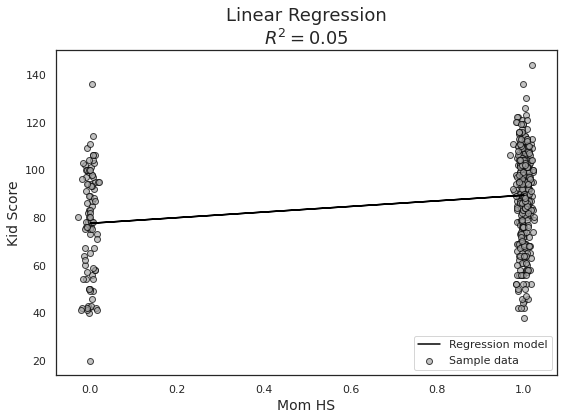

In [116]:
# SOURCE: https://matplotlib.org/stable/plot_types/index.html

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(kidiq.mom_hs, fit1.fittedvalues, color='k', label='Regression model')
ax.scatter(rand_jitter(kidiq.mom_hs), kidiq.kid_score, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom HS', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit1.rsquared_adj, fontsize=18)

fig.tight_layout();

### A single continuous predictor

Now let's model the children's test scores given a a continuous predictor, mother's score on an IQ test.

We fit the model using `statsmodels`, which allows users to fit statistical models using `R`-style formulas.  Internally, `statsmodels` uses the `patsy` package to convert formulas and data to the matrices that are used in model fitting.

We can think of the line as representing predicted test scores for children at each of several maternal IQ levels, or average test scores for subpopulations defined by these scores.

In [117]:
# Fit regression model
fit2 = smf.ols('kid_score ~ 1 + mom_iq', data=kidiq).fit()

# Inspect results
print(fit2.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     108.6
Date:                Thu, 12 May 2022   Prob (F-statistic):           7.66e-23
Time:                        15:48:07   Log-Likelihood:                -1875.6
No. Observations:                 434   AIC:                             3755.
Df Residuals:                     432   BIC:                             3763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.7998      5.917      4.360      0.0

### `seaborn` 

[`regplot`](https://seaborn.pydata.org/generated/seaborn.regplot.html): Plot data and a linear regression model fit

Child's test score plotted versus maternal IQ with regression line superimposed.  Each point on the line can be conceived of either as a predicted child test score for children with mothers who have the corresponding IQ, or as the average score for a subpopulation of children with mothers with that IQ.

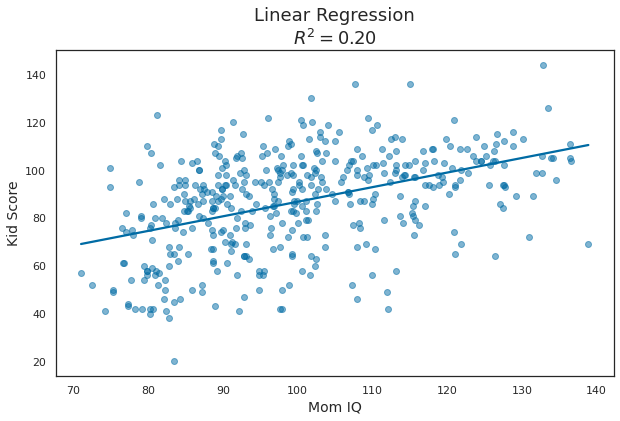

In [118]:
# SOURCE: https://seaborn.pydata.org/generated/seaborn.regplot.html

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.regplot(x='mom_iq',
                 y='kid_score',
                 data=kidiq,
                 fit_reg=True,   # Fit a regression line
                 ci=None,
                 scatter_kws={'alpha': 0.5}, # Set transparency to 50%
                 ax=ax)
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ', fontsize=14)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit2.rsquared_adj, fontsize=18);

### [`matplotlib`](https://matplotlib.org/stable/plot_types/index.html)

[plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html): Plot y versus x as lines and/or markers

[scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html): A scatter plot of y versus x with varying marker size and/or color

Child's test score plotted versus maternal IQ with regression line superimposed.  Each point on the line can be conceived of either as a predicted child test score for children with mothers who have the corresponding IQ, or as the average score for a subpopulation of children with mothers with that IQ.

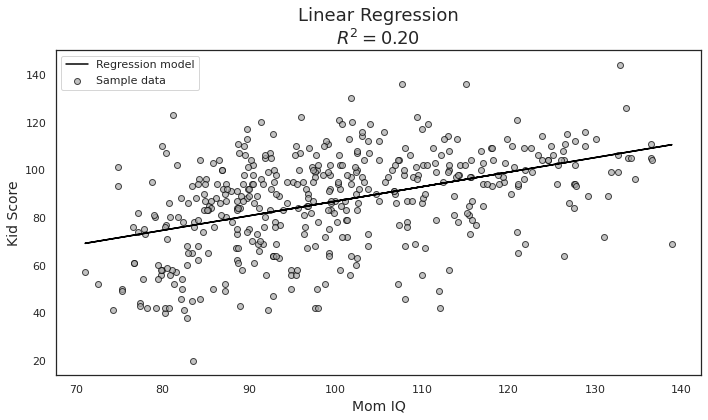

In [119]:
# SOURCE: https://matplotlib.org/stable/plot_types/index.html

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(kidiq.mom_iq, fit2.fittedvalues, color='k', label='Regression model')
ax.scatter(kidiq.mom_iq, kidiq.kid_score, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit2.rsquared_adj, fontsize=18)

fig.tight_layout();

## Exercise: 

**Step 1:** Create a centered version of the mom_iq variable

**Step 2:** Regress kid_score on the centered version of mom_iq

**Step 3:** Plot the data (kid_score and centered mom_iq) and regression line

## Questions:

**1.** How do the coefficient estimates differ from those in `fit2`?

**2.** How does the x-axis in a plot for this model differ from that for `fit2`?

In [120]:
# SOURCE: https://pandas.pydata.org/docs/user_guide/dsintro.html#column-selection-addition-deletion

# Create a centered version of the mom_iq variable
kidiq['mom_iq_c'] = kidiq['mom_iq'] - kidiq['mom_iq'].mean()
kidiq

kid_score  mom_hs      mom_iq  mom_work  mom_age   mom_iq_c
0           65       1  121.117529         4       27  21.117529
1           98       1   89.361882         4       25 -10.638118
2           85       1  115.443165         4       27  15.443165
3           83       1   99.449639         3       25  -0.550361
4          115       1   92.745710         4       27  -7.254290
..         ...     ...         ...       ...      ...        ...
429         94       0   84.877412         4       21 -15.122588
430         76       1   92.990392         4       23  -7.009608
431         50       0   94.859708         2       24  -5.140292
432         88       1   96.856624         2       21  -3.143376
433         70       1   91.253336         2       25  -8.746664

[434 rows x 6 columns]

In [121]:
# SOURCE: https://www.statsmodels.org/stable/example_formulas.html

# Fit regression model using centered version of mom_iq
fit2_c = smf.ols('kid_score ~ 1 + mom_iq_c', data=kidiq).fit()

# Inspect results
print(fit2_c.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     108.6
Date:                Thu, 12 May 2022   Prob (F-statistic):           7.66e-23
Time:                        15:48:09   Log-Likelihood:                -1875.6
No. Observations:                 434   AIC:                             3755.
Df Residuals:                     432   BIC:                             3763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     86.7972      0.877     98.993      0.0

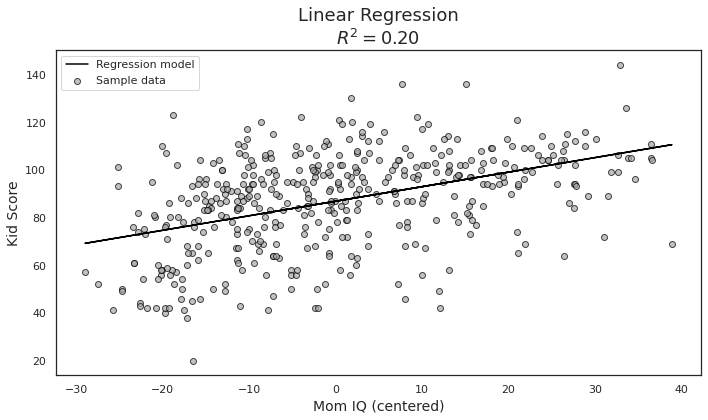

In [122]:
# SOURCE: https://matplotlib.org/stable/plot_types/index.html

# Plot the data (kid_score and mom_iq_c) and regression line
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(kidiq.mom_iq_c, fit2_c.fittedvalues, color='k', label='Regression model')
ax.scatter(kidiq.mom_iq_c, kidiq.kid_score, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ (centered)', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit2.rsquared_adj, fontsize=18)

fig.tight_layout();

## Two predictors

### No interaction

Now consider a linear regression of child test scores on two predictors: the maternal high school indicator and maternal IQ.

We fit the model using `statsmodels`, which allows users to fit statistical models using `R`-style formulas.  Internally, `statsmodels` uses the `patsy` package to convert formulas and data to the matrices that are used in model fitting.

This model forces the slope of the regression of child's test score on mother's IQ score to be the same for each maternal education subgroup.  Later, we consider an *interaction* model in which the slopes of the two lines differ.

In [123]:
# Fit regression model
fit3 = smf.ols('kid_score ~ 1 + mom_hs + mom_iq', data=kidiq).fit()

# Inspect results
print(fit3.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     58.72
Date:                Thu, 12 May 2022   Prob (F-statistic):           2.79e-23
Time:                        15:48:10   Log-Likelihood:                -1872.0
No. Observations:                 434   AIC:                             3750.
Df Residuals:                     431   BIC:                             3762.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.7315      5.875      4.380      0.0

In [124]:
# SOURCE: https://www.statology.org/matplotlib-abline/
def abline(intercept, slope, **params):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', **params)

In [125]:
fit3.params

Intercept    25.731538
mom_hs        5.950117
mom_iq        0.563906
dtype: float64

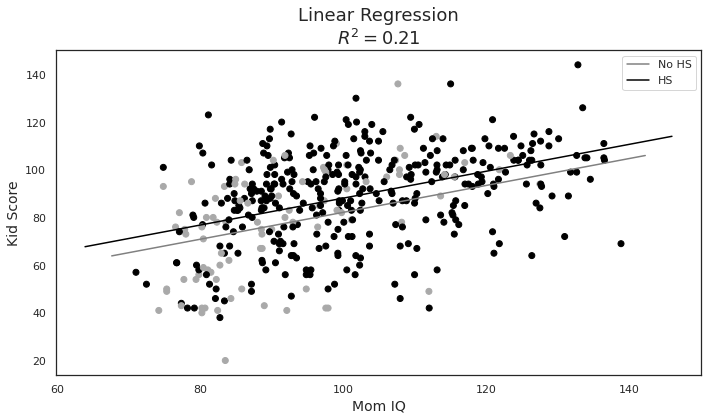

In [126]:
# SOURCE: https://matplotlib.org/stable/plot_types/index.html

fig, ax = plt.subplots(figsize=(10, 6))

colors = {1:'black', 0:'darkgray'}
b_hat = fit3.params

ax.scatter(kidiq.mom_iq, kidiq.kid_score, color=kidiq.mom_hs.map(colors))
abline(b_hat['Intercept'],                 b_hat['mom_iq'], color='gray',  label='No HS')
abline(b_hat['Intercept']+b_hat['mom_hs'], b_hat['mom_iq'], color='black', label='HS')
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit3.rsquared_adj, fontsize=18)

fig.tight_layout();

### Interaction

In the previous model, the slope of the regression of child's test score on mother's IQ was forced to be equal across subgroups defined by mother's high school completion, but inspection of the data suggests that the slopes differ substantially.  A remedy for this is to include an *interaction* between `mom_hs` and `mom_iq` -- that is, a new predictor defined as the product of these two variables.  This allows the slope to vary across subgroups.

In [127]:
# Fit regression model
fit4 = smf.ols('kid_score ~ 1 + mom_hs + mom_iq + mom_hs:mom_iq', data=kidiq).fit()

# Inspect results
print(fit4.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     42.84
Date:                Thu, 12 May 2022   Prob (F-statistic):           3.07e-24
Time:                        15:48:12   Log-Likelihood:                -1867.5
No. Observations:                 434   AIC:                             3743.
Df Residuals:                     430   BIC:                             3759.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -11.4820     13.758     -0.835

In [128]:
fit4.params

Intercept       -11.482021
mom_hs           51.268223
mom_iq            0.968889
mom_hs:mom_iq    -0.484275
dtype: float64

### `seaborn` 

[`lmplot`](https://seaborn.pydata.org/generated/seaborn.lmplot.html): Plot data and regression model fits across a FacetGrid.  It is intended as a convenient interface to fit regression models across conditional subsets of a dataset.

Regression lines of child's test score on mother's IQ with different colors for children of mothers who completed high school (orange) and those whose mothers did not complete high school (blue).  The interaction allows for a different slope in each group, with orange and blue lines corresponding to the orange and blue points.

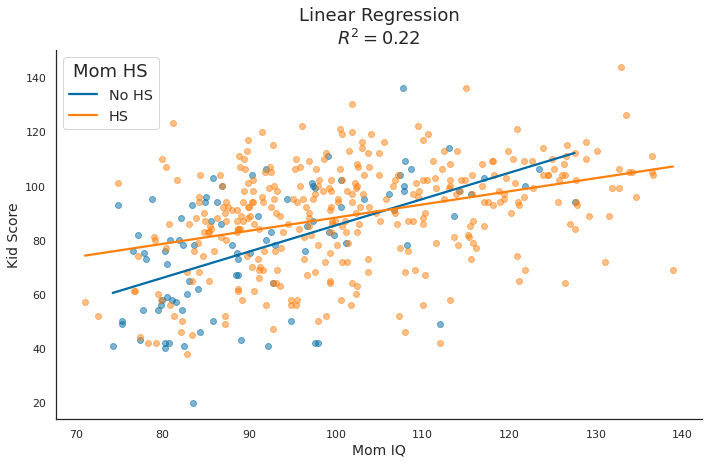

In [129]:
sns.lmplot(y='kid_score',
           x='mom_iq',
           hue='mom_hs',
           data=kidiq,
           fit_reg=True,   # Fit a regression line
           ci=None,
           legend=None,
           height=6,
           aspect=10/6,
           scatter_kws={'alpha': 0.5}) # Set transparency to 50%
plt.legend(labels=['No HS', 'HS'], title = 'Mom HS', 
           fontsize = 'large', title_fontsize = '18')
plt.ylabel('Kid Score', fontsize=14)
plt.xlabel('Mom IQ', fontsize=14)
plt.title('Linear Regression\n$R^2= %.2f$' % fit4.rsquared_adj, fontsize=18);

### [`matplotlib`](https://matplotlib.org/stable/plot_types/index.html)

[scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html): A scatter plot of y versus x with varying marker size and/or color

[abline](https://www.statology.org/matplotlib-abline/): Plot a line based on an intercept and slope (defined above beneath fit3)

Regression lines of child's test score on mother's IQ with different colors for children of mothers who completed high school (black) and those whose mothers did not complete high school (gray).  The interaction allows for a different slope in each group, with black and gray lines corresponding to the black and gray points.

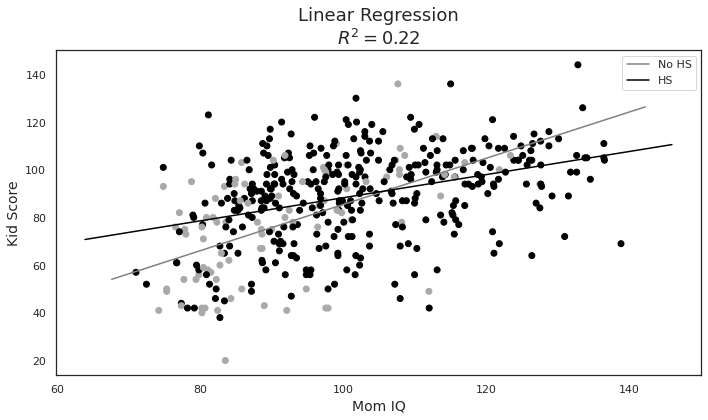

In [130]:
# SOURCE: https://matplotlib.org/stable/plot_types/index.html

fig, ax = plt.subplots(figsize=(10, 6))

colors = {1:'black', 0:'darkgray'}
b_hat = fit4.params

ax.scatter(kidiq.mom_iq, kidiq.kid_score, color=kidiq.mom_hs.map(colors))
abline(b_hat['Intercept'], b_hat['mom_iq'], color='gray',  label='No HS')
abline(b_hat['Intercept']+b_hat['mom_hs'], b_hat['mom_iq']+b_hat['mom_hs:mom_iq'], color='black', label='HS')
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit4.rsquared_adj, fontsize=18)

fig.tight_layout();

### Indicator variables

We can express comparisons using regression with indicator ("dummy") variables.  Let's use the `earnings` dataset to analyze differences in average weight among subpopulations defined by height, sex, and ethnicity.

In [131]:
# Load data into a DataFrame
earnings = pd.read_csv('https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Earnings/data/earnings.csv')
earnings

height  weight  male     earn  earnk ethnicity  education  \
0         74   210.0     1  50000.0   50.0     White       16.0   
1         66   125.0     0  60000.0   60.0     White       16.0   
2         64   126.0     0  30000.0   30.0     White       16.0   
3         65   200.0     0  25000.0   25.0     White       17.0   
4         63   110.0     0  50000.0   50.0     Other       16.0   
...      ...     ...   ...      ...    ...       ...        ...   
1811      61   120.0     0  15000.0   15.0     White       18.0   
1812      64   130.0     0   8000.0    8.0     White       12.0   
1813      72   194.0     1  60000.0   60.0     White       12.0   
1814      63   155.0     0  15000.0   15.0     Other       14.0   
1815      68   150.0     1   6000.0    6.0     White       12.0   

      mother_education  father_education  walk  exercise  smokenow  tense  \
0                 16.0              16.0     3         3       2.0    0.0   
1                 16.0              16.0     6         5       1.0    0.0   
2                 16.0              16.0     8         1       2.0    1.0   
3                 17.0               NaN     8         1       2.0    0.0   
4                 16.0              16.0     5         6       2.0    0.0   
...                ...               ...   ...       ...       ...    ...   
1811              18.0              18.0     6         1       2.0    0.0   
1812              12.0              12.0     1         1       1.0    7.0   
1813              12.0              12.0     2         1       2.0    0.0   
1814              14.0              14.0     6         1       2.0    2.0   
1815              12.0              12.0     1         6       1.0    2.0   

      angry  age  
0       0.0   45  
1       0.0   58  
2       1.0   29  
3       0.0   57  
4       0.0   91  
...     ...  ...  
1811    0.0   82  
1812    7.0   33  
1813    0.0   50  
1814    2.0   69  
1815    2.0   27  

[1816 rows x 15 columns]

To improve interpretation of the fitted model, we will use a centered version of height as a predictor:

In [132]:
# Create a centered version of the height variable
earnings['height_c'] = earnings['height'] - earnings['height'].mean()

print(np.round(earnings['height'].mean() , decimals=2))

66.57


### Using indicator variables for multiple levels of a categorical predictor

The ethnicity variable takes on four levels, as we can see using `.value_counts()` on the Series.

In [133]:
# View the four levels of ethnicity
earnings.ethnicity.value_counts()

White       1494
Black        180
Hispanic     104
Other         38
Name: ethnicity, dtype: int64

We include ethnicity in our regression as a factor, treating it explicitly as categorical by using the `C()` operator:

In [134]:
# Fit regression model
fit4_earn = smf.ols('weight ~ 1 + height_c + male + C(ethnicity)', data=earnings).fit()

# Inspect results
print(fit4_earn.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     166.0
Date:                Thu, 12 May 2022   Prob (F-statistic):          4.00e-145
Time:                        15:48:14   Log-Likelihood:                -8537.0
No. Observations:                1789   AIC:                         1.709e+04
Df Residuals:                    1783   BIC:                         1.712e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Changing the baseline factor level

When including a factor variable in a regression, any of the levels can be used as the baseline.  By default, it orders the factors in alphabetical order, hence in this case `Black` is the first cateogry and is used as the baseline.  We can change the baseline category by directly setting the levels when constructing the factor with `pandas`:

In [135]:
# SOURCE: https://pandas.pydata.org/docs/user_guide/categorical.html
# SOURCE: https://www.statsmodels.org/stable/contrasts.html

# Change the baseline category by directly setting the levels when constructing the categorical, factor variable
cat_type = CategoricalDtype(categories=['White', 'Black', 'Hispanic', 'Other'], ordered=False)

earnings['eth'] = earnings['ethnicity'].astype(cat_type)

earnings.head()

height  weight  male     earn  earnk ethnicity  education  \
0      74   210.0     1  50000.0   50.0     White       16.0   
1      66   125.0     0  60000.0   60.0     White       16.0   
2      64   126.0     0  30000.0   30.0     White       16.0   
3      65   200.0     0  25000.0   25.0     White       17.0   
4      63   110.0     0  50000.0   50.0     Other       16.0   

   mother_education  father_education  walk  exercise  smokenow  tense  angry  \
0              16.0              16.0     3         3       2.0    0.0    0.0   
1              16.0              16.0     6         5       1.0    0.0    0.0   
2              16.0              16.0     8         1       2.0    1.0    1.0   
3              17.0               NaN     8         1       2.0    0.0    0.0   
4              16.0              16.0     5         6       2.0    0.0    0.0   

   age  height_c    eth  
0   45  7.431167  White  
1   58 -0.568833  White  
2   29 -2.568833  White  
3   57 -1.568833  White  
4   91 -3.568833  Other

In [136]:
# View the categorical variable's data and metadata
earnings.eth

0       White
1       White
2       White
3       White
4       Other
        ...  
1811    White
1812    White
1813    White
1814    Other
1815    White
Name: eth, Length: 1816, dtype: category
Categories (4, object): ['White', 'Black', 'Hispanic', 'Other']

In [137]:
# View the categorical variable's category codes
earnings.eth.cat.codes

0       0
1       0
2       0
3       0
4       3
       ..
1811    0
1812    0
1813    0
1814    3
1815    0
Length: 1816, dtype: int8

In [138]:
# View the factor variable's categories
earnings.eth.cat.categories

Index(['White', 'Black', 'Hispanic', 'Other'], dtype='object')

This model uses `White` as the baseline category because we listed it first when setting up the factor variable `eth`.

In [139]:
# Fit regression model
fit5_earn = smf.ols('weight ~ 1 + height_c + male + eth', data=earnings).fit()

# Inspect results
print(fit5_earn.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     166.0
Date:                Thu, 12 May 2022   Prob (F-statistic):          4.00e-145
Time:                        15:48:15   Log-Likelihood:                -8537.0
No. Observations:                1789   AIC:                         1.709e+04
Df Residuals:                    1783   BIC:                         1.712e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         151.3283      1.041    1

### Mean weights for each ethnicity

By regressing `weight` on our factor variable `eth` and removing the intercept using the `-1` syntax, our model estimates the mean weights for each ethnicity.

In [140]:
# Fit regression model
fit1_earn = smf.ols('weight ~ eth - 1', data=earnings).fit()

# Inspect results
print(fit1_earn.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.059
Date:                Thu, 12 May 2022   Prob (F-statistic):             0.0273
Time:                        15:48:15   Log-Likelihood:                -8874.2
No. Observations:                1789   AIC:                         1.776e+04
Df Residuals:                    1785   BIC:                         1.778e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
eth[White]      156.4721      0.901    173.602

Here we group by our factor variable `eth` and calculate the mean weight by ethnicity to confirm that our above model does indeed estimate the mean weights for each ethnicity.

In [141]:
earnings.groupby(['eth'])['weight'].mean().round(4)

eth
White       156.4721
Black       160.1173
Hispanic    152.0388
Other       143.1081
Name: weight, dtype: float64

An alternative approach is to create indicators for the four ethnic groups directly.  It's not necessary to name the new variables in this way, but this sort of naming can sometimes make it easier to keep track.

In [142]:
# An alternative approach is to create indicators for the four ethnic groups directly
earnings['eth_White']    = np.where(earnings['ethnicity'] == 'White', 1.0, 0.0)
earnings['eth_Black']    = np.where(earnings['ethnicity'] == 'Black', 1.0, 0.0)
earnings['eth_Hispanic'] = np.where(earnings['ethnicity'] == 'Hispanic', 1.0, 0.0)
earnings['eth_Other']    = np.where(earnings['ethnicity'] == 'Other', 1.0, 0.0)

earnings.head()

height  weight  male     earn  earnk ethnicity  education  \
0      74   210.0     1  50000.0   50.0     White       16.0   
1      66   125.0     0  60000.0   60.0     White       16.0   
2      64   126.0     0  30000.0   30.0     White       16.0   
3      65   200.0     0  25000.0   25.0     White       17.0   
4      63   110.0     0  50000.0   50.0     Other       16.0   

   mother_education  father_education  walk  ...  smokenow  tense  angry  age  \
0              16.0              16.0     3  ...       2.0    0.0    0.0   45   
1              16.0              16.0     6  ...       1.0    0.0    0.0   58   
2              16.0              16.0     8  ...       2.0    1.0    1.0   29   
3              17.0               NaN     8  ...       2.0    0.0    0.0   57   
4              16.0              16.0     5  ...       2.0    0.0    0.0   91   

   height_c    eth eth_White  eth_Black  eth_Hispanic  eth_Other  
0  7.431167  White       1.0        0.0           0.0        0.0  
1 -0.568833  White       1.0        0.0           0.0        0.0  
2 -2.568833  White       1.0        0.0           0.0        0.0  
3 -1.568833  White       1.0        0.0           0.0        0.0  
4 -3.568833  Other       0.0        0.0           0.0        1.0  

[5 rows x 21 columns]

### Different Intercepts, Same Slopes

In [143]:
# SOURCE: https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

This model includes a factor variable for ethnicity `eth` and a continuous variable for centered height `height_c`.  Since this model does not include an interaction between the factor variable and continuous variable, this model estimates different intercepts for the different ethnicities and forces the slope of the regression of `weight` on `height_c` to be the same for each ethnic group.

In [144]:
# Fit regression model
fit6_earn = smf.ols('weight ~ 1 + height_c + eth', data=earnings).fit()
fit6_earn.params

Intercept          155.725456
eth[T.Black]         5.243858
eth[T.Hispanic]      0.809459
eth[T.Other]        -5.255728
height_c             4.948151
dtype: float64

View the separate regression lines, one for each ethnic group.  The lines have different intercepts, but the same slope.

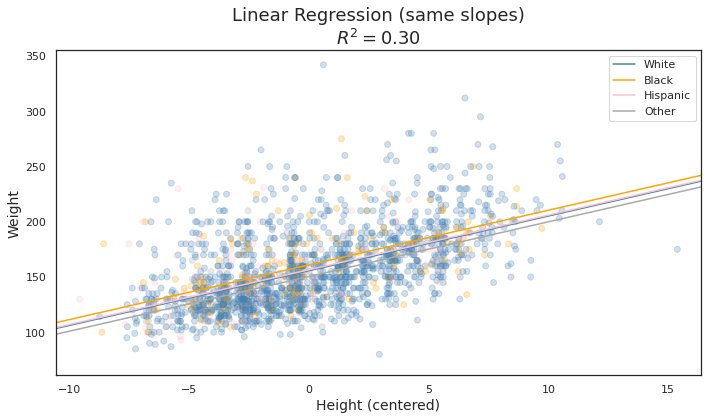

In [145]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'White':'steelblue', 'Black':'orange', 'Hispanic':'pink', 'Other':'darkgray'}
b_hat = fit6_earn.params


x_length = rand_jitter(earnings.height_c)

ax.scatter(x_length, earnings.weight, color=earnings.eth.map(colors), alpha=0.25)

abline(b_hat['Intercept'],                          b_hat['height_c'], color='steelblue',     label='White')
abline(b_hat['Intercept']+b_hat['eth[T.Black]'],    b_hat['height_c'], color='orange',   label='Black')
abline(b_hat['Intercept']+b_hat['eth[T.Hispanic]'], b_hat['height_c'], color='pink',     label='Hispanic')
abline(b_hat['Intercept']+b_hat['eth[T.Other]'],    b_hat['height_c'], color='darkgray', label='Other')

ax.set_xlim(left=min(x_length)-1, right=max(x_length)+1)
ax.set_ylabel('Weight', fontsize=14)
ax.set_xlabel('Height (centered)', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression (same slopes)\n$R^2= %.2f$' % fit6_earn.rsquared_adj, fontsize=18)

fig.tight_layout();

### Different Intercepts, Different Slopes

This model includes a factor variable for ethnicity `eth` and a continuous variable for centered height `height_c`.  Since this model includes an interaction between the factor variable and continuous variable, this model estimates different intercepts for the different ethnicities, as well as different slopes of the regression of `weight` on `height_c` for each ethnic group.

In [146]:
# Fit regression model
fit7_earn = smf.ols('weight ~ 1 + height_c + eth + height_c:eth', data=earnings).fit()
fit7_earn.params

Intercept                   155.701151
eth[T.Black]                  5.173766
eth[T.Hispanic]              -0.235332
eth[T.Other]                 -5.303178
height_c                      5.109223
height_c:eth[T.Black]        -0.709302
height_c:eth[T.Hispanic]     -1.337663
height_c:eth[T.Other]        -0.209302
dtype: float64

View the separate regression lines, one for each ethnic group.  The lines have different intercepts and different slopes.

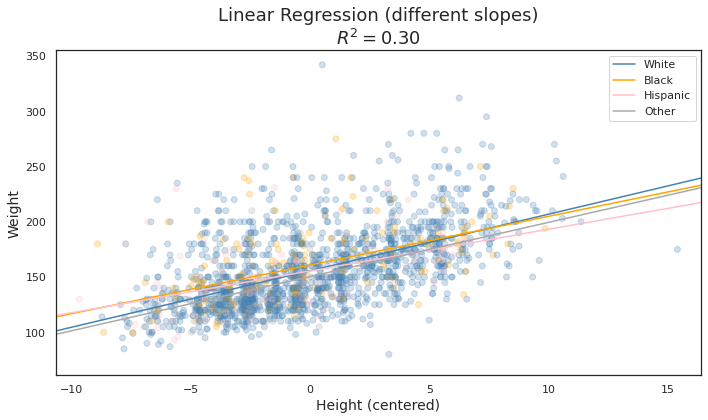

In [147]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'White':'steelblue', 'Black':'orange', 'Hispanic':'pink', 'Other':'darkgray'}
b_hat = fit7_earn.params


x_length = rand_jitter(earnings.height_c)

ax.scatter(x_length, earnings.weight, color=earnings.eth.map(colors), alpha=0.25)

abline(b_hat['Intercept'],                          b_hat['height_c'],                                   color='steelblue',     label='White')
abline(b_hat['Intercept']+b_hat['eth[T.Black]'],    b_hat['height_c']+b_hat['height_c:eth[T.Black]'],    color='orange',   label='Black')
abline(b_hat['Intercept']+b_hat['eth[T.Hispanic]'], b_hat['height_c']+b_hat['height_c:eth[T.Hispanic]'], color='pink',     label='Hispanic')
abline(b_hat['Intercept']+b_hat['eth[T.Other]'],    b_hat['height_c']+b_hat['height_c:eth[T.Other]'],    color='darkgray', label='Other')

ax.set_xlim(left=min(x_length)-1, right=max(x_length)+1)
ax.set_ylabel('Weight', fontsize=14)
ax.set_xlabel('Height (centered)', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression (different slopes)\n$R^2= %.2f$' % fit7_earn.rsquared_adj, fontsize=18)

fig.tight_layout();

### Transformations

Skew and outliers create problems even for simple statistics like the mean.  Their potential for mischief grows as we move to more complicated analysis.  Fortunately skew can often be reduced, and outliers pulled in, by *power transformation*, which refers to a family of simple transformations:

* Y^q  ; q > 0

* log Y ; q = 0

* --(Y^q) ; q < 0

Since power transformations are undefined for some values, we may need to add a positive constant before transformation.  For example, log Y is undefined for Y lte 0.  If the lower data value of Y is 0, we modify the q = 0 transformation to log(Y + 1).

The *ladder of powers* (Tukey, 1977) is a graduated series of power transformations:

* Y^3  ; q = 3 (higher powers *reduce negative skew*)

* Y^2  ; q = 2

* Y^1  ; q = 1 (the raw data)

* Y^0.5  ; q = 0.5

* log Y ; q = 0 (powers less than 1 *reduce positive skew*)

* --(Y^--0.5) ; q = --0.5

* --(Y^--1) ; q = --1 (to preserve order, add minus signs after raising to powers less than zero)

By selecting an appropriate power transformation, we may be able to pull in outliers and make a skewed distribution more symmetrical.  Analysis then proceeds using the transformed data.




### Model: babies

The data used in this example is the `babies` dataset from [Bayesian Modeling and Computation In Python](https://raw.githubusercontent.com/BayesianModelingandComputationInPython/BookCode_Edition1/main/data/babies.csv).

In [148]:
# Load data into a DataFrame
babies = pd.read_csv('https://raw.githubusercontent.com/BayesianModelingandComputationInPython/BookCode_Edition1/main/data/babies.csv')
babies

Month  Length
0        0    48.5
1        0    50.5
2        0    50.5
3        0    52.0
4        0    47.5
..     ...     ...
795     24    87.5
796     24    82.5
797     24    88.5
798     24    89.0
799     24    87.0

[800 rows x 2 columns]

In [263]:
babies.describe().round(1)

Month  Length
count  800.0   800.0
mean    11.4    71.7
std      7.5    11.3
min      0.0    45.5
25%      5.0    64.0
50%     11.0    72.5
75%     18.0    81.0
max     24.0    93.0

Scatter plot of the nonlinear relationship between a baby's age (in months) and observed, or measured length (in centimeters).

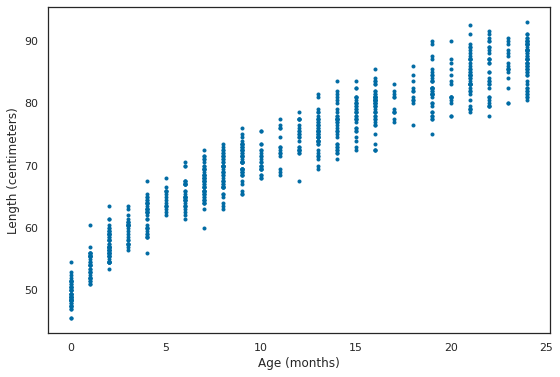

In [264]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(babies.Month, babies.Length, marker='.')
plt.xlabel('Age (months)')
plt.ylabel('Length (centimeters)');

The relationship is visibly nonlinear -- the rate of increase in length appears to taper off at higher ages (similar to the square root function), so let's try regressing Length on the square root of Month.

In [150]:
# Fit regression model
fit1_babies = smf.ols('Length ~ np.sqrt(Month)', data=babies).fit()

# Inspect results
print(fit1_babies.summary())

                            OLS Regression Results                            
Dep. Variable:                 Length   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.192e+04
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        15:48:18   Log-Likelihood:                -1965.1
No. Observations:                 800   AIC:                             3934.
Df Residuals:                     798   BIC:                             3944.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         46.7058      0.249    187.

The babies' ages are binned into discrete months, so many of the points overlap.  Let's use a function that jitters the points (slightly shifts their positions) to make it easier to see individual points.

In [151]:
# SOURCE: https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

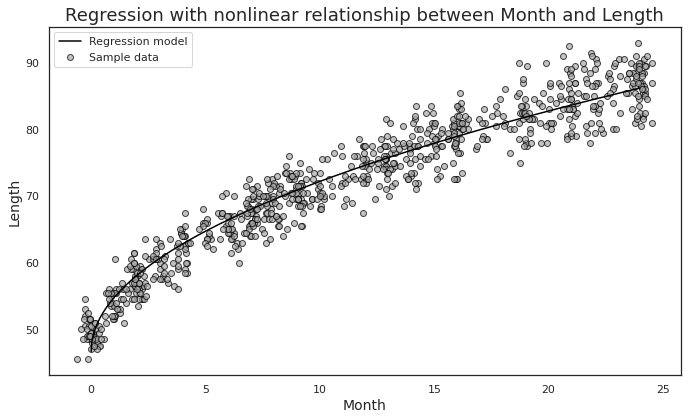

In [152]:
# SOURCE: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
x = np.linspace(babies['Month'].min(), babies['Month'].max(), 1000)
y = fit1_babies.predict(pd.DataFrame({'Month': x}))
f = interp1d(x, y, kind = "quadratic")
xnew = np.linspace(babies['Month'].min(), babies['Month'].max(), 1000)
ynew = f(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(rand_jitter(babies.Month), babies.Length, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(xnew, ynew, linestyle='-', color='black', label='Regression model')

ax.set_ylabel('Length', fontsize=14)
ax.set_xlabel('Month', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Regression with nonlinear relationship between Month and Length', fontsize=18)

fig.tight_layout();

### Model: earnings

The data used in this example is the `earnings` dataset from [Regression and Other Stories](https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Earnings/data/earnings.csv).  We restrict our dataset to observations with positive earnings that are less than $400,000 (to exclude an unusually high observation).

In [273]:
earnings_without_high_earnings_point = earnings.loc[(earnings['earn'] > 0) & (earnings['earn'] < 400000), :]

earnings_without_high_earnings_point[['earn', 'height']].describe().round(1)

earn  height
count    1628.0  1628.0
mean    23343.7    66.8
std     20540.2     3.9
min       200.0    57.0
25%     10000.0    64.0
50%     19000.0    66.0
75%     30000.0    70.0
max    200000.0    82.0

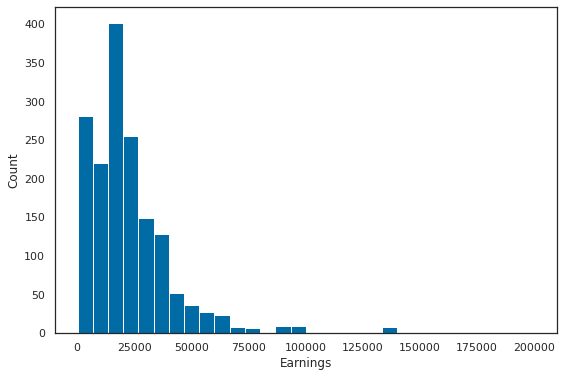

In [275]:
fig, ax = plt.subplots(figsize=(9,6))
ax.hist(earnings_without_high_earnings_point.earn, bins=30)
plt.xlabel('Earnings')
plt.ylabel('Count');

The distribution of earnings exhibits positive skew (i.e. it is skewed to the right).  To reduce the positive skew (i.e. pull in the right hand tail), let's use the natural log of earnings.

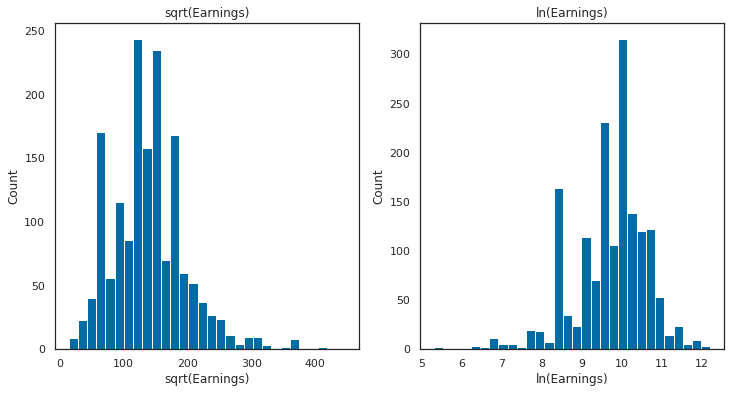

In [294]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].hist(np.sqrt(earnings_without_high_earnings_point.earn), bins=30)
ax[0].set_xlabel('sqrt(Earnings)')
ax[0].set_ylabel('Count')
ax[0].set_title('sqrt(Earnings)')

ax[1].hist(np.log(earnings_without_high_earnings_point.earn), bins=30)
ax[1].set_xlabel('ln(Earnings)')
ax[1].set_ylabel('Count')
ax[1].set_title('ln(Earnings)');

In [283]:
#fig, ax = plt.subplots(figsize=(9,6))
#ax.scatter(earnings_without_high_earnings_point.height, 
#           earnings_without_high_earnings_point.earn, 
#           marker='.')
#plt.xlabel('Height')
#plt.ylabel('Earnings');

In [284]:
#fig, ax = plt.subplots(figsize=(9,6))
#ax.scatter(earnings_without_high_earnings_point.height, 
#           np.log(earnings_without_high_earnings_point.earn), 
#           marker='.')
#plt.xlabel('Height')
#plt.ylabel('ln(Earnings)');

Given that we have taken the natural log of earnings to reduce its positive skew, let's regress the natural log of earnings on height.

In [153]:
# Fit regression model
fit_log_earnings = smf.ols('np.log(earn) ~ height', data=earnings.loc[earnings['earn'] > 0, :]).fit()

# Inspect results
print(fit_log_earnings.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(earn)   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     103.0
Date:                Thu, 12 May 2022   Prob (F-statistic):           1.65e-23
Time:                        15:48:20   Log-Likelihood:                -2097.1
No. Observations:                1629   AIC:                             4198.
Df Residuals:                    1627   BIC:                             4209.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9087      0.376     15.712      0.0

Given that we regressed the natural log of earnings on height, let's plot the natural log of earnings on the y-axis, height on the x-axis, along with the fitted regression line.

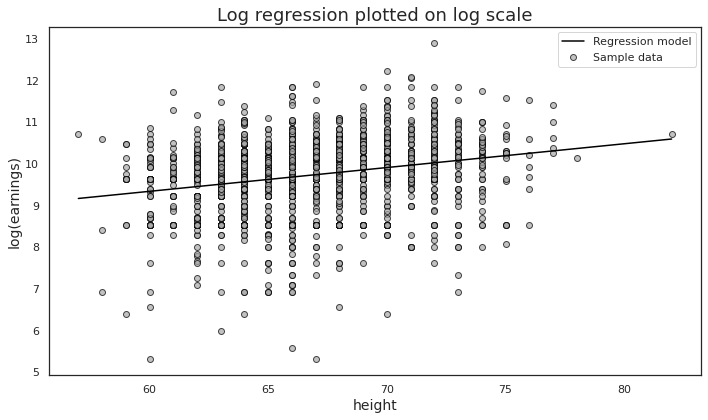

In [278]:
# SOURCE: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
x = np.linspace(earnings['height'].min(), earnings['height'].max(), 1000)
y = fit_log_earnings.predict(pd.DataFrame({'height': x}))
f = interp1d(x, y, kind = "linear")
xnew = np.linspace(earnings['height'].min(), earnings['height'].max(), 1000)
ynew = f(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(earnings.height, np.log(earnings.earn), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(xnew, ynew, linestyle='-', color='black', label='Regression model')

ax.set_ylabel('log(earnings)', fontsize=14)
ax.set_xlabel('height', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Log regression plotted on log scale', fontsize=18)

fig.tight_layout();

Given that we regressed the natural log of earnings on height, the relationship between these two variables is linear, but the relationship between earnings and height is curved.  Exponentiation is the inverse transformation for having taken the natural log of a value, so to re-express earnings in its natural units we need to exponentiate the predicted values before plotting them.  We use SciPy's `interp1d` or `make_interp_spline` functions to fit and display a curve instead of a straight line.

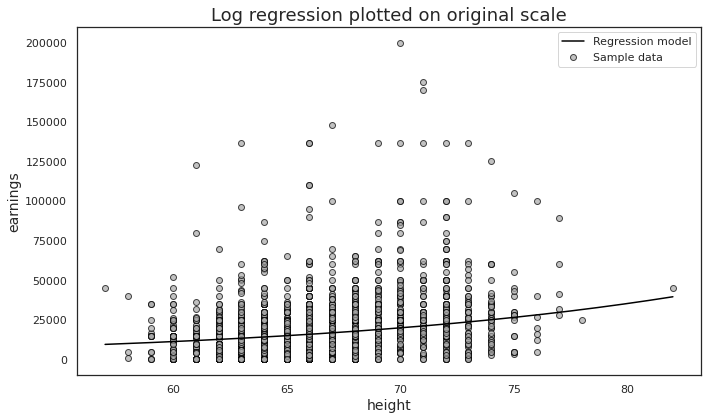

In [282]:
# SOURCE: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
x = np.linspace(earnings['height'].min(), earnings['height'].max(), 1000)
y = fit_log_earnings.predict(pd.DataFrame({'height': x}))

f = interp1d(x, y, kind = "quadratic") # kind: the string has to be one of 'linear', 'nearest', 'nearest-up', 'zero', 'slinear', 'quadratic', 'cubic', 'previous', or 'next'.

xnew = np.linspace(earnings['height'].min(), earnings['height'].max(), 1000)

ynew = np.exp(f(xnew)) # # Exponentiate (inverse transformation of natural log)


fig, ax = plt.subplots(figsize=(10, 6))

data_excluding_pt = earnings.loc[earnings.earn < 400000, ['earn', 'height']]
ax.scatter(data_excluding_pt.height, data_excluding_pt.earn, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(xnew, ynew, linestyle='-', color='black', label='Regression model')

ax.set_ylabel('earnings', fontsize=14)
ax.set_xlabel('height', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Log regression plotted on original scale', fontsize=18)

fig.tight_layout();

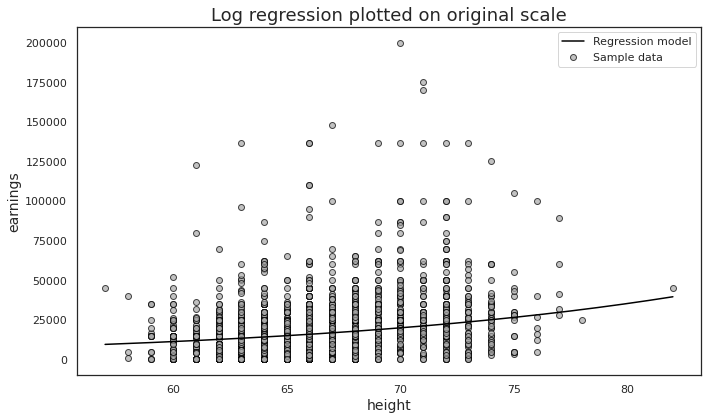

In [281]:
# SOURCE: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.make_interp_spline.html
x = np.linspace(earnings['height'].min(), earnings['height'].max(), 1000)
y = fit_log_earnings.predict(pd.DataFrame({'height': x}))

f = make_interp_spline(x, y, k=2) # Default is cubic, k=3

xnew = np.linspace(earnings['height'].min(), earnings['height'].max(), 1000)

ynew = np.exp(f(xnew)) # Exponentiate (inverse transformation of natural log)


fig, ax = plt.subplots(figsize=(10, 6))

data_excluding_pt = earnings.loc[earnings.earn < 400000, ['earn', 'height']]
ax.scatter(data_excluding_pt.height, data_excluding_pt.earn, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(xnew, ynew, linestyle='-', color='black', label='Regression model')

ax.set_ylabel('earnings', fontsize=14)
ax.set_xlabel('height', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Log regression plotted on original scale', fontsize=18)

fig.tight_layout();

### Model: Water Use

We can use [`files.upload()`](https://colab.research.google.com/notebooks/io.ipynb) to upload the `concord1.csv` dataset from our local laptop computer into our Colab notebook environment.  The file will only be available during the current session (i.e. it will go away when the runtime disconnects).

In [156]:
from google.colab import files
files.upload()

Saving concord1.csv to concord1 (1).csv


{'concord1.csv': b'case,water81,water80,water79,income,educat,retire,peop81,cpeop,peop80\n5,2300,3500,3500,35,18,0,3,0,3\n6,2500,4600,4100,60,20,0,5,0,5\n7,4000,3800,5500,30,16,0,6,1,5\n8,500,1500,1700,20,11,1,1,-1,2\n9,4400,4300,3700,50,20,0,2,0,2\n10,1900,1500,1600,18,13,0,5,0,5\n11,3600,3500,3500,25,14,1,3,0,3\n12,2200,2400,4900,21,20,1,2,0,2\n13,2300,1900,2900,13,11,0,4,0,4\n14,2200,2500,3900,30,20,0,2,0,2\n15,3500,3300,4600,13,11,0,3,0,3\n16,3600,3100,5200,30,20,0,5,0,5\n17,3000,3700,5400,35,16,0,5,0,5\n18,4400,3700,14500,15,16,0,7,-1,8\n19,4000,4000,2800,35,12,0,8,1,7\n20,1600,1500,2000,15,13,0,4,0,4\n21,1000,1200,1300,19,12,1,1,0,1\n22,1400,1700,1800,35,10,0,3,0,3\n23,3900,4700,NA,25,16,1,3,0,3\n24,1100,1100,1200,7,11,1,2,0,2\n25,1300,1500,1700,25,12,0,4,0,4\n26,3100,2800,3700,29,13,0,4,0,4\n27,1600,2500,3000,26,16,0,2,0,2\n28,500,300,1000,30,18,1,2,0,2\n29,7100,5300,6200,20,13,0,8,0,8\n30,800,1000,1600,17,13,1,2,0,2\n31,2300,1900,2900,30,12,0,2,0,2\n33,1200,1200,1000,25,18,0,1,

The data used in this example is the `concord1` dataset from [Regression with Graphics](https://stats.oarc.ucla.edu/other/examples/rwg/regression-with-graphics-by-lawrence-hamilton-table-of-contents/).

In [157]:
concord = pd.read_csv('/content/concord1.csv')
concord

case  water81  water80  water79  income  educat  retire  peop81  cpeop  \
0       5     2300     3500   3500.0      35      18       0       3      0   
1       6     2500     4600   4100.0      60      20       0       5      0   
2       7     4000     3800   5500.0      30      16       0       6      1   
3       8      500     1500   1700.0      20      11       1       1     -1   
4       9     4400     4300   3700.0      50      20       0       2      0   
..    ...      ...      ...      ...     ...     ...     ...     ...    ...   
491   512     2800     4400      NaN      20      16       0       2      0   
492   513     3600     3600      NaN      23      12       0       4      0   
493   514     1100     4700      NaN      45      16       0       2      0   
494   515     2800     1900      NaN      25      16       0       2      0   
495   516     2400     4300      NaN      53      14       0       4      0   

     peop80  
0         3  
1         5  
2         5  
3         2  
4         2  
..      ...  
491       2  
492       4  
493       2  
494       2  
495       4  

[496 rows x 10 columns]

The raw data are positively skewed.  In the text, the author tries taking the natural log of the values (q = 0), but the transformation is too powerful (the data become negatively skewed).  Given the *ladder of powers*, the author next tries taking the square root (q = 0.5) of the values, but the transformation is not strong enough.  Given the need for a transformation between q = 0 and q = 0.5, the author finds that the power q = 0.3 works well to reduce the skew.

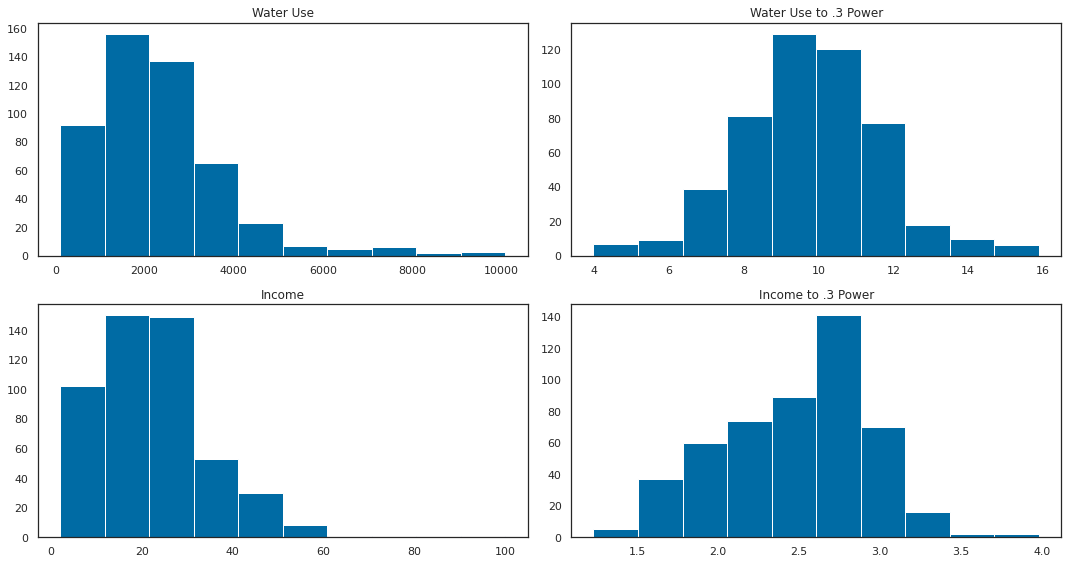

In [158]:
# Univariate distributions of water use and income are improved by a 0.3 power transformation
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

axes[0,0].hist(concord['water81'])
axes[0,0].set_title('Water Use')

axes[0,1].hist(np.power(concord['water81'], 0.3))
axes[0,1].set_title('Water Use to .3 Power')

axes[1,0].hist(concord['income'])
axes[1,0].set_title('Income')

axes[1,1].hist(np.power(concord['income'],  0.3))
axes[1,1].set_title('Income to .3 Power')

plt.tight_layout();

Given that we have raised both water use and income to the 0.3 power to reduce their positive skew, let's regress water use raised to the 0.3 power on income raised to the 0.3 power.

In [159]:
# wtr81_3 = np.power(concord['water81'], 0.3)
# inc_3   = np.power(concord['income'],  0.3)

# Fit regression model
fit_concord = smf.ols('np.power(water81, 0.3) ~ 1 + np.power(income, 0.3)', data=concord).fit()

# Inspect results
print(fit_concord.summary())

                              OLS Regression Results                              
Dep. Variable:     np.power(water81, 0.3)   R-squared:                       0.204
Model:                                OLS   Adj. R-squared:                  0.202
Method:                     Least Squares   F-statistic:                     126.2
Date:                    Thu, 12 May 2022   Prob (F-statistic):           3.08e-26
Time:                            15:48:38   Log-Likelihood:                -969.73
No. Observations:                     496   AIC:                             1943.
Df Residuals:                         494   BIC:                             1952.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

Given that we regressed water use^0.3 on income^0.3, the relationship between these two variables is linear, but the relationship between water use and income is curved.  Since we raised both variables to the 0.3 power, the inverse transformation is (1 / 0.3), so to re-express water use in its natural units we need to raise the predicted values to the (1 / 0.3) power before plotting them.  We use SciPy's `interp1d` or `make_interp_spline` functions to fit and display a curve instead of a straight line.

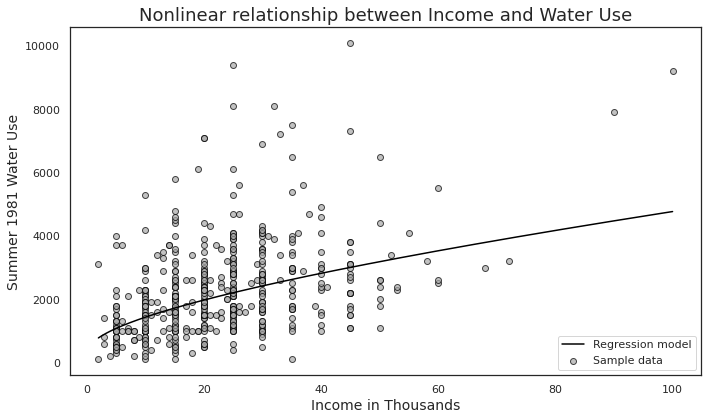

In [297]:
# SOURCE: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
x = np.linspace(concord['income'].min(), concord['income'].max(), 1000)
# y = np.power( fit_concord.predict(pd.DataFrame({'income': x})) , (1/0.3) ) # Note the inverse transformation (1 / 0.3)
y = fit_concord.predict(pd.DataFrame({'income': x}))
f = interp1d(x, y, kind = "quadratic")
xnew = np.linspace(concord['income'].min(), concord['income'].max(), 1000)
ynew = np.power( f(xnew) , (1/0.3) ) # Note the inverse transformation (1 / 0.3)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(concord.income, concord.water81, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(xnew, ynew, linestyle='-', color='black', label='Regression model')

ax.set_ylabel('Summer 1981 Water Use', fontsize=14)
ax.set_xlabel('Income in Thousands', fontsize=14)
ax.legend(fontsize=11, loc=4)
ax.set_title('Nonlinear relationship between Income and Water Use', fontsize=18)

fig.tight_layout();

## statsmodels (API interface)

In addition to supporting specifying models using `R`-style formulas, `statsmodels` also supports specifying models as `numpy` arrays.

To fit most of the models with this format, you will need to create two design matrices:
* The first is a matrix of endogenous variable(s) (i.e. dependent, response, regressand, etc.)
* The second is a matrix of exogenous variable(s) (i.e. independent, predictor, regressor, etc.)

With this format, by default, `statsmodels` does not add a column of ones to the matrix of exogenous predictor variables (to represent the Intercept), so we use [`add_constant`](https://www.statsmodels.org/stable/generated/statsmodels.tools.tools.add_constant.html) to add the columns of ones to our set of predictor variables.

### Model: kid_score

In [299]:
# SOURCE: https://www.statsmodels.org/stable/gettingstarted.html
# Tools: add_constant https://www.statsmodels.org/stable/api.html

y = kidiq['kid_score']
X = kidiq['mom_hs']
X = sm.add_constant(X)

# Describe regression model
model1 = sm.OLS(y,X)

# Fit regression model
results1 = model1.fit()

# Inspect results
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     25.69
Date:                Thu, 12 May 2022   Prob (F-statistic):           5.96e-07
Time:                        20:15:30   Log-Likelihood:                -1911.8
No. Observations:                 434   AIC:                             3828.
Df Residuals:                     432   BIC:                             3836.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.5484      2.059     37.670      0.0

### Model: weight

The `patsy` module provides a convenient function to prepare design matrices using `R`-like formulas. You can find more information [here](https://patsy.readthedocs.io/en/latest/).

We use `patsy`’s `dmatrices` function to create design matrices:

In [162]:
# SOURCE: https://www.statsmodels.org/stable/gettingstarted.html
# Tools: add_constant https://www.statsmodels.org/stable/api.html

# Alternatively:
# y, X = dmatrices('weight ~ 1 + height_c + male + eth_Black + eth_Hispanic + eth_Other', data=earnings, return_type='dataframe')

y, X = dmatrices('weight ~ 1 + height_c + male + eth', data=earnings, return_type='dataframe')

y[:3]

weight
0   210.0
1   125.0
2   126.0

In [163]:
X[:3]

Intercept  eth[T.Black]  eth[T.Hispanic]  eth[T.Other]  height_c  male
0        1.0           0.0              0.0           0.0  7.431167   1.0
1        1.0           0.0              0.0           0.0 -0.568833   0.0
2        1.0           0.0              0.0           0.0 -2.568833   0.0

Notice that `dmatrices` has

* split the categorical ethnicity variable into a set of indicator variables.

* added a constant to the exogenous regressors matrix.

* returned pandas DataFrames instead of simple numpy arrays. This is useful because DataFrames allow statsmodels to carry-over meta-data (e.g. variable names) when reporting results.

## Model fit and summary

Fitting a model in `statsmodels` typically involves 3 easy steps:

1. Use the model class to describe the model

2. Fit the model using a class method

3. Inspect the results using a summary method

For OLS, this is achieved by:

In [164]:
# Describe regression model
model1_earn = sm.OLS(y,X)

# Fit regression model
results1_earn = model1_earn.fit()

# Inspect results
print(results1_earn.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     166.0
Date:                Thu, 12 May 2022   Prob (F-statistic):          4.00e-145
Time:                        15:48:39   Log-Likelihood:                -8537.0
No. Observations:                1789   AIC:                         1.709e+04
Df Residuals:                    1783   BIC:                         1.712e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         151.3283      1.041    1

# Bambi: a high-level Bayesian model-building interface written in Python

## A single predictor

### A single binary predictor

In [175]:
# Initialize the model
model1_bmb = bmb.Model('kid_score ~ 1 + mom_hs', kidiq)

# Inspect model object
model1_bmb

Formula: kid_score ~ 1 + mom_hs
Family name: Gaussian
Link: identity
Observations: 434
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 86.7972, sigma: 110.1032)
    mom_hs ~ Normal(mu: 0.0, sigma: 124.2132)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 20.3872)

In [176]:
model1_bmb.build()

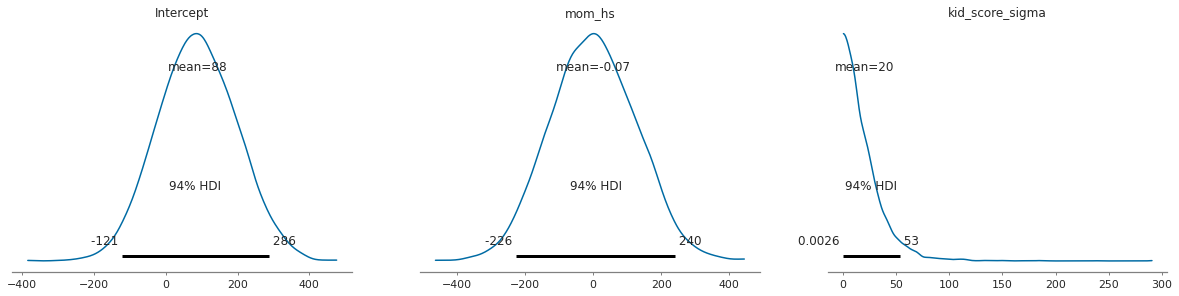

In [177]:
model1_bmb.plot_priors();

In [178]:
print(model1_bmb.backend.model)

            Intercept ~ Normal
               mom_hs ~ Normal
kid_score_sigma_log__ ~ TransformedDistribution
      kid_score_sigma ~ HalfStudentT
            kid_score ~ Normal


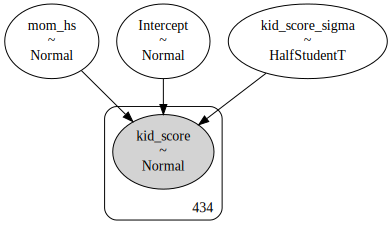

In [179]:
model1_bmb.graph()

In [300]:
fit1_bmb = model1_bmb.fit() # draws=5000, chains=4, cores=None)
fit1_bmb

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [kid_score_sigma, mom_hs, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

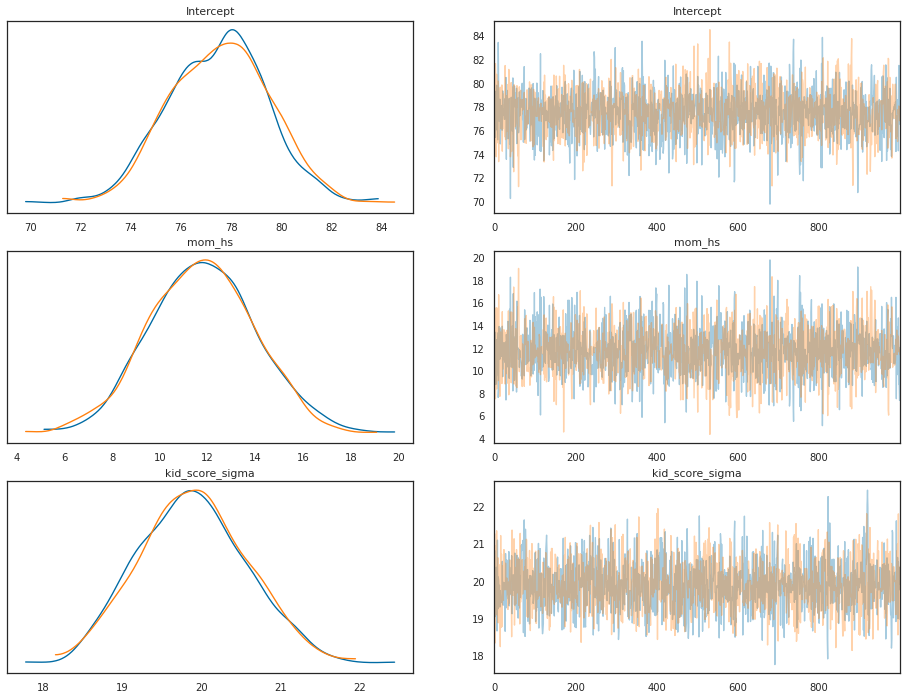

In [301]:
az.plot_trace(fit1_bmb, compact=False, figsize=(16,12));

In [302]:
az.summary(fit1_bmb)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        77.514  2.005  73.795   81.171      0.040    0.028    2591.0   
mom_hs           11.792  2.236   7.412   15.751      0.044    0.032    2558.0   
kid_score_sigma  19.895  0.686  18.661   21.180      0.013    0.009    2755.0   

                 ess_tail  r_hat  
Intercept          1376.0    1.0  
mom_hs             1685.0    1.0  
kid_score_sigma    1523.0    1.0

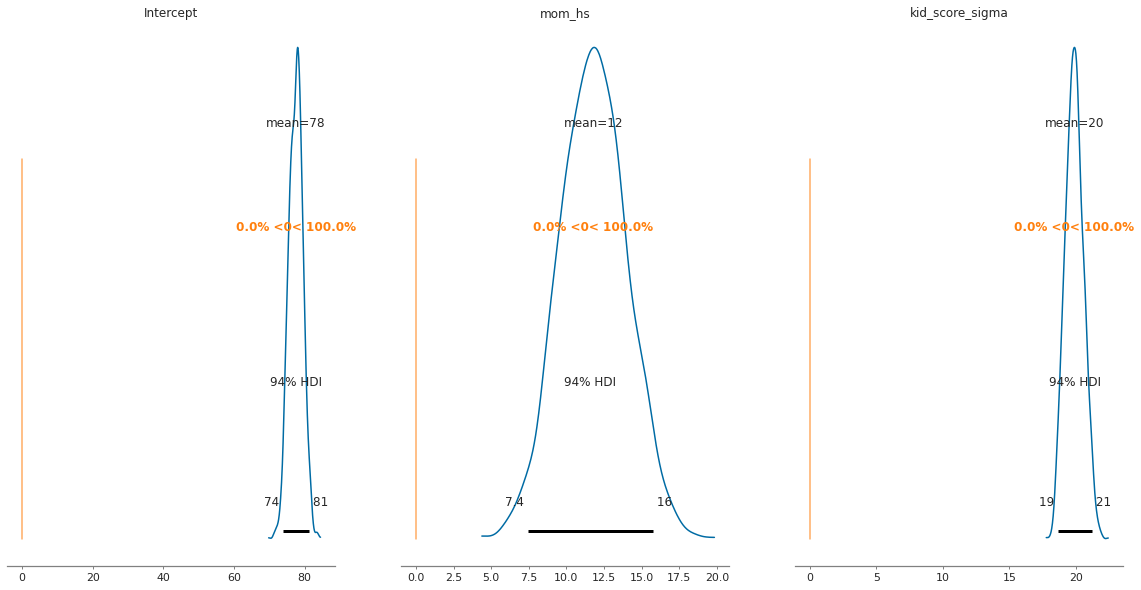

In [303]:
az.plot_posterior(fit1_bmb, ref_val=0, figsize=(20,10));

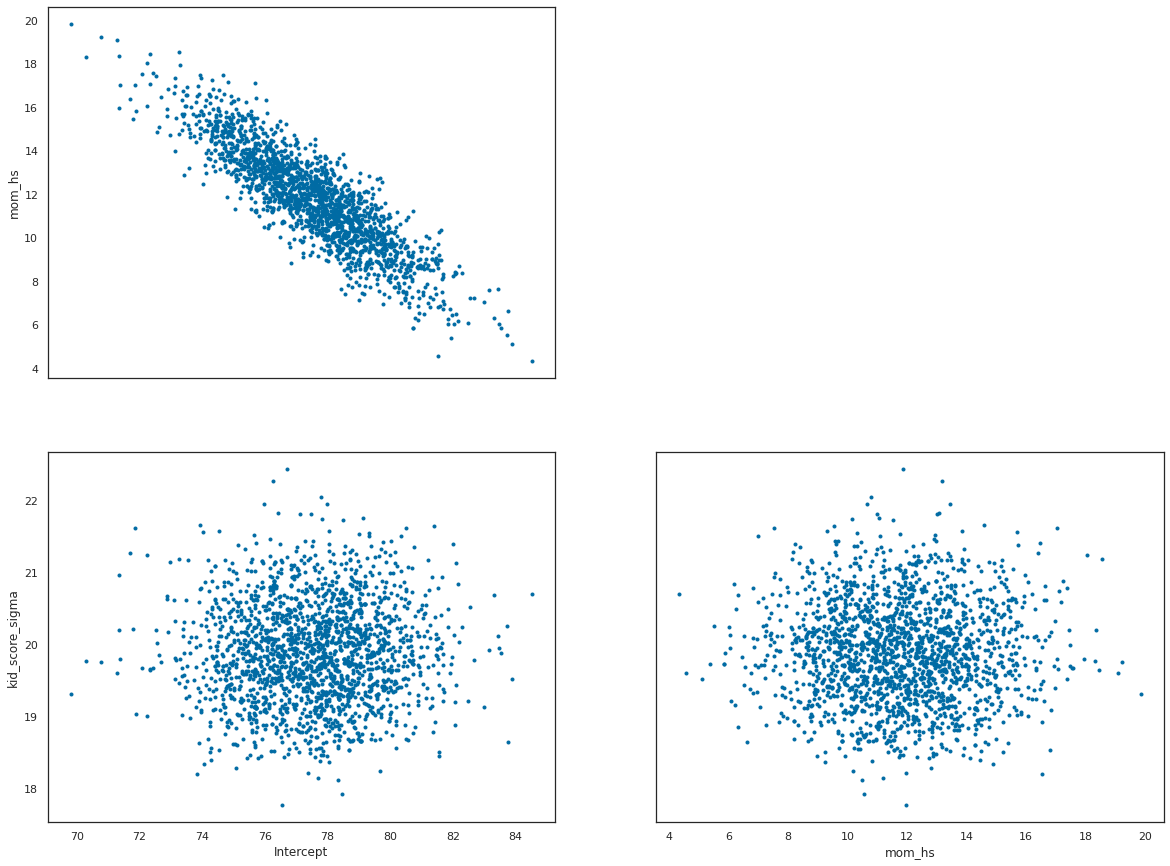

In [304]:
az.plot_pair(fit1_bmb, figsize=(20,15));

In [305]:
posterior_predictive = model1_bmb.predict(fit1_bmb, kind="pps", draws=500)
fit1_bmb

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

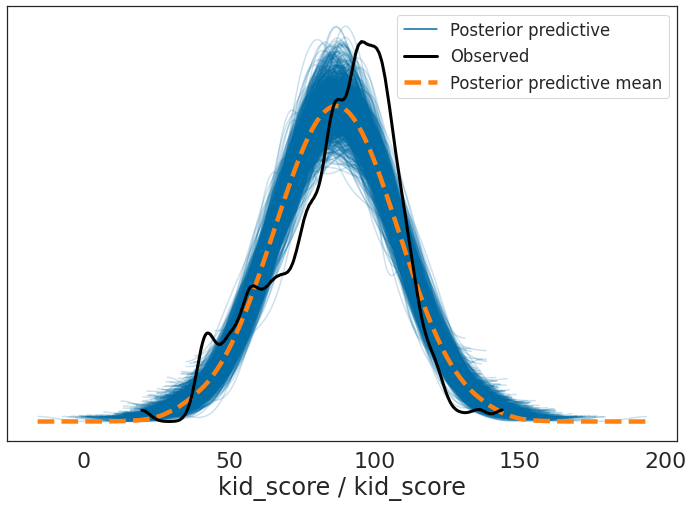

In [306]:
az.plot_ppc(fit1_bmb, figsize=(12,8));

In [307]:
az.loo(fit1_bmb)

Computed from 2000 by 434 log-likelihood matrix

         Estimate       SE
elpd_loo -1914.77    13.78
p_loo        3.01        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      434  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [308]:
y_true = kidiq.kid_score.values
y_pred = fit1_bmb.posterior_predictive.stack(sample=("chain", "draw"))["kid_score"].values.T

fit1_bmb_r2_score = az.r2_score(y_true, y_pred)
fit1_bmb_r2_score

r2        0.348104
r2_std    0.016405
dtype: float64

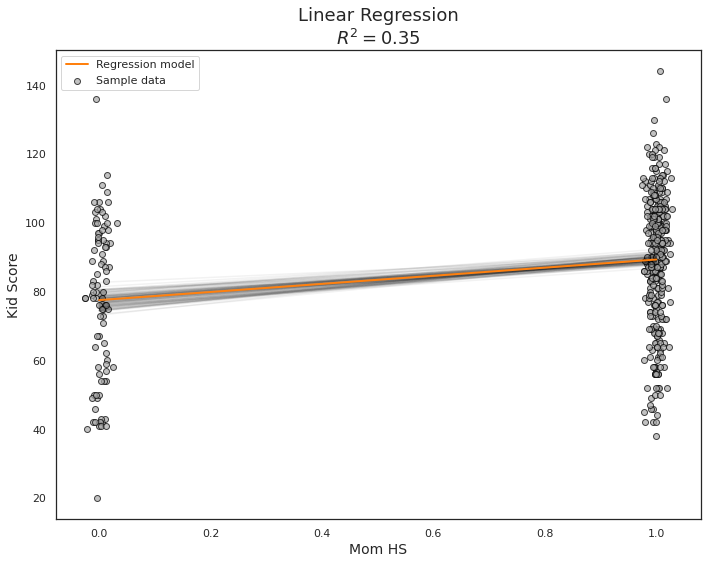

In [309]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)

fig, ax = plt.subplots(figsize=(10, 8))

x_axis = xr.DataArray(np.linspace(0, 1, num=2000), dims=["x_plot"])
mu_pred = fit1_bmb.posterior["Intercept"] + fit1_bmb.posterior["mom_hs"] * x_axis
mu_mean = mu_pred.mean(dim=("chain", "draw"))
mu_plot = mu_pred.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:100]

plt.scatter(rand_jitter(kidiq.mom_hs), kidiq.kid_score, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(x_axis, mu_plot.isel(sample=random_subset), color="black", alpha=0.05)
plt.plot(x_axis, mu_mean, color="C1", lw=2.0, label='Regression model')

ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom HS', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit1_bmb_r2_score[0], fontsize=18)

fig.tight_layout();

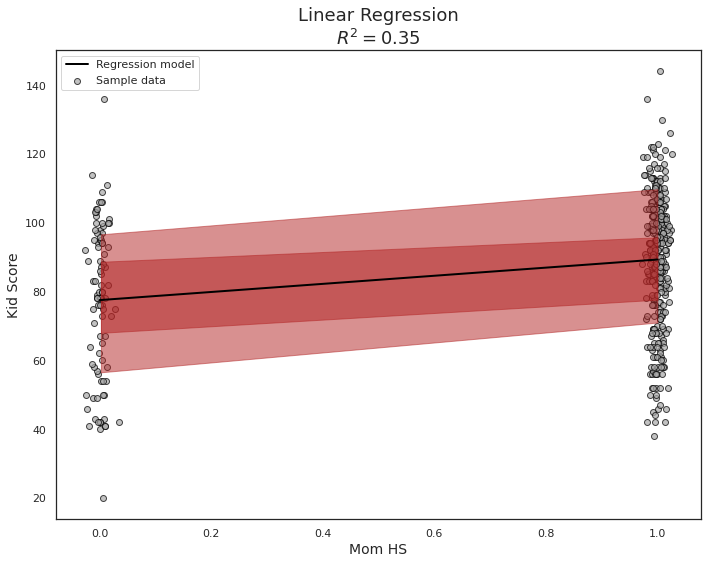

In [310]:
# SOURCE: https://bambinos.github.io/bambi/main/notebooks/t_regression.html
fig, ax = plt.subplots(figsize=(10, 8))

# Plot data
ax.scatter(rand_jitter(kidiq.mom_hs), kidiq.kid_score, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')


# Plot linear regression
x_range = np.linspace(min(kidiq.mom_hs), max(kidiq.mom_hs), 2000)
y_pred = fit1_bmb.posterior.mom_hs.values.mean() * x_range + fit1_bmb.posterior.Intercept.values.mean()
plt.plot(x_range, y_pred, color='k',linestyle='-', lw=2.0, label='Regression model')

# Plot HDIs
for interval in [0.38, 0.68]:
    az.plot_hdi(kidiq.mom_hs, fit1_bmb.posterior_predictive.kid_score,
                hdi_prob=interval, color='firebrick')

ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom HS', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit1_bmb_r2_score[0], fontsize=18)

fig.tight_layout();

### A single continuous predictor

In [191]:
# Initialize the model
model2_bmb = bmb.Model('kid_score ~ 1 + mom_iq', kidiq)

# Inspect model object
model2_bmb

Formula: kid_score ~ 1 + mom_iq
Family name: Gaussian
Link: identity
Observations: 434
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 86.7972, sigma: 343.9751)
    mom_iq ~ Normal(mu: 0.0, sigma: 3.4018)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 20.3872)

In [192]:
model2_bmb.build()

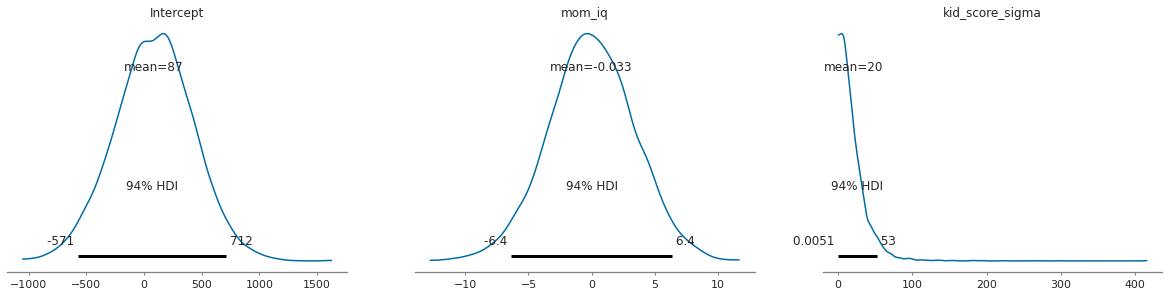

In [193]:
model2_bmb.plot_priors();

In [194]:
print(model2_bmb.backend.model)

            Intercept ~ Normal
               mom_iq ~ Normal
kid_score_sigma_log__ ~ TransformedDistribution
      kid_score_sigma ~ HalfStudentT
            kid_score ~ Normal


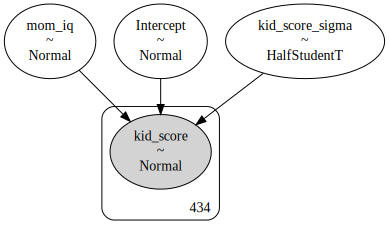

In [195]:
model2_bmb.graph()

In [311]:
fit2_bmb = model2_bmb.fit() # draws=5000, chains=4, cores=None
fit2_bmb

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [kid_score_sigma, mom_iq, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

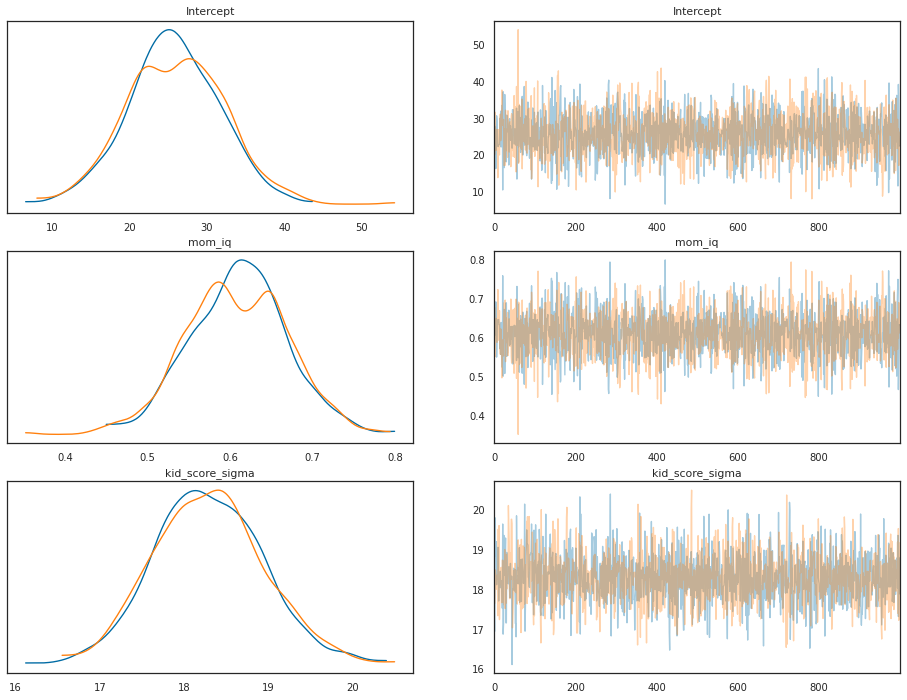

In [312]:
az.plot_trace(fit2_bmb, compact=False, figsize=(16,12));

In [313]:
az.summary(fit2_bmb)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        25.869  6.051  14.475   37.109      0.108    0.081    3131.0   
mom_iq            0.609  0.060   0.499    0.722      0.001    0.001    3182.0   
kid_score_sigma  18.290  0.644  17.120   19.519      0.013    0.009    2522.0   

                 ess_tail  r_hat  
Intercept          1579.0    1.0  
mom_iq             1549.0    1.0  
kid_score_sigma    1482.0    1.0

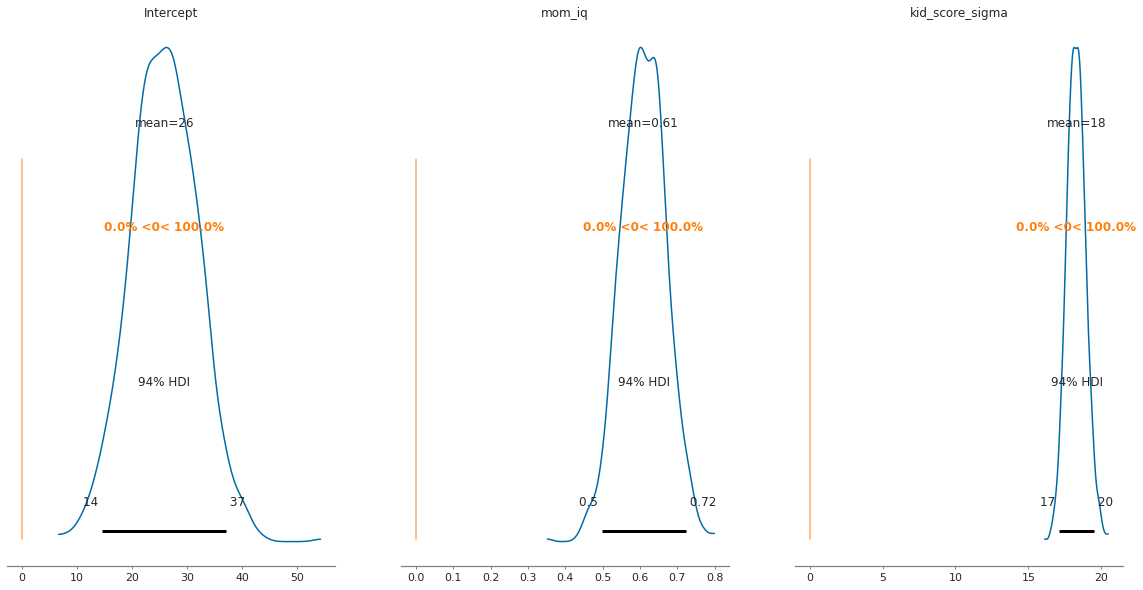

In [314]:
az.plot_posterior(fit2_bmb, ref_val=0, figsize=(20,10));

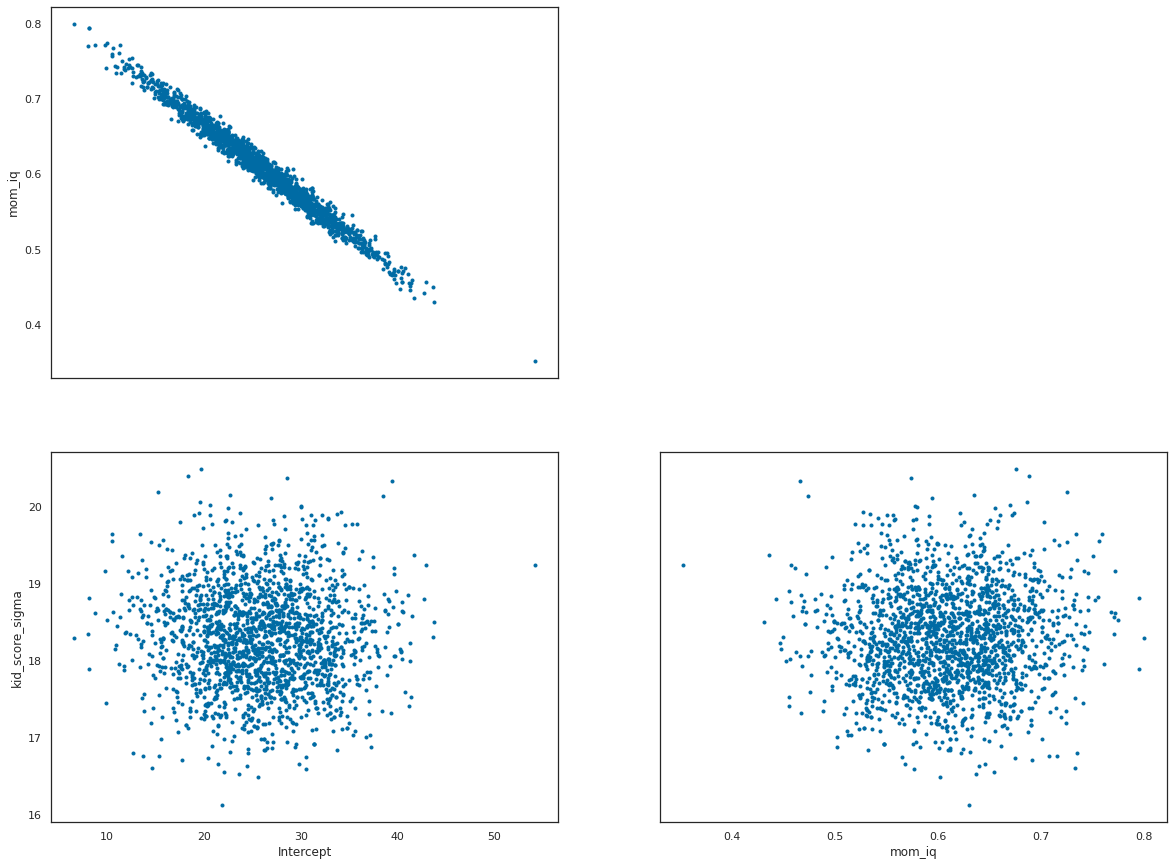

In [315]:
az.plot_pair(fit2_bmb, figsize=(20,15));

In [316]:
posterior_predictive = model2_bmb.predict(fit2_bmb, kind="pps", draws=500)
fit2_bmb

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

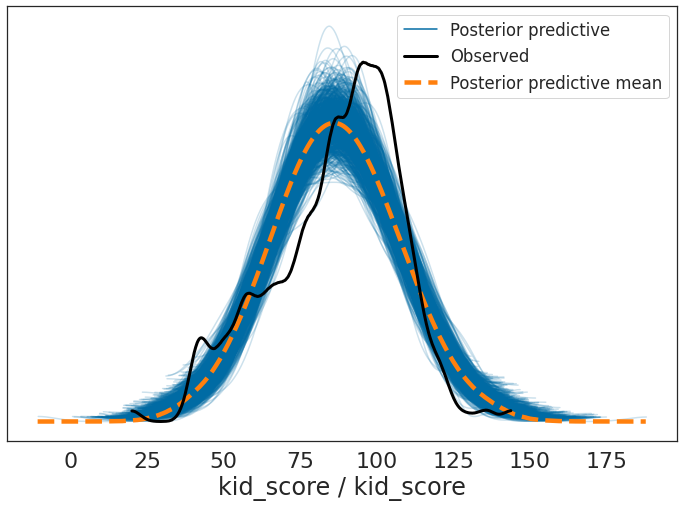

In [317]:
az.plot_ppc(fit2_bmb, figsize=(12,8));

In [318]:
az.loo(fit2_bmb)

Computed from 2000 by 434 log-likelihood matrix

         Estimate       SE
elpd_loo -1878.73    14.50
p_loo        3.06        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      434  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [319]:
y_true = kidiq.kid_score.values
y_pred = fit2_bmb.posterior_predictive.stack(sample=("chain", "draw"))["kid_score"].values.T

fit2_bmb_r2_score = az.r2_score(y_true, y_pred)
fit2_bmb_r2_score

r2        0.385439
r2_std    0.018940
dtype: float64

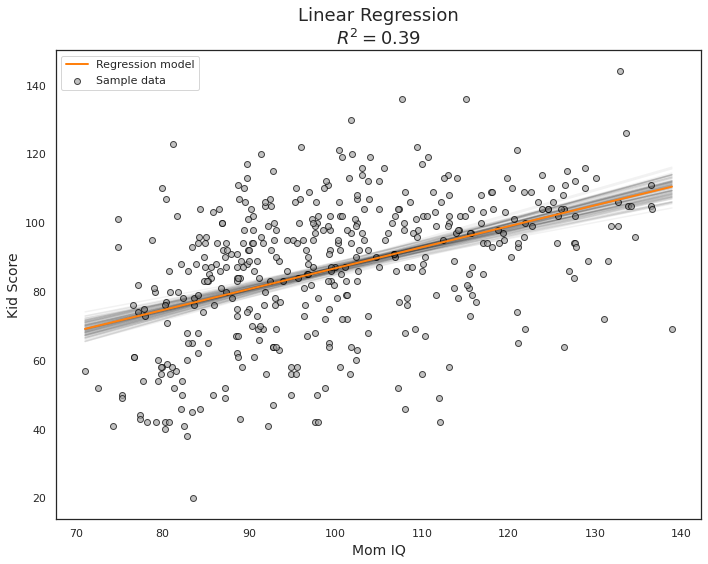

In [320]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)

fig, ax = plt.subplots(figsize=(10, 8))

x_axis = xr.DataArray(np.linspace(min(kidiq.mom_iq), max(kidiq.mom_iq), 2000), dims=["x_plot"])
mu_pred = fit2_bmb.posterior["Intercept"] + fit2_bmb.posterior["mom_iq"] * x_axis
mu_mean = mu_pred.mean(dim=("chain", "draw"))
mu_plot = mu_pred.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:100]

plt.scatter(kidiq.mom_iq, kidiq.kid_score, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(x_axis, mu_plot.isel(sample=random_subset), color="black", alpha=0.05)
plt.plot(x_axis, mu_mean, color="C1", lw=2.0, label='Regression model')

ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit2_bmb_r2_score[0], fontsize=18)

fig.tight_layout();

## Two predictors

### No interaction

In [206]:
# Initialize the model
model3_bmb = bmb.Model('kid_score ~ 1 + mom_hs + mom_iq', kidiq)

# Inspect model object
model3_bmb

Formula: kid_score ~ 1 + mom_hs + mom_iq
Family name: Gaussian
Link: identity
Observations: 434
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 86.7972, sigma: 357.5526)
    mom_hs ~ Normal(mu: 0.0, sigma: 124.2132)
    mom_iq ~ Normal(mu: 0.0, sigma: 3.4018)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 20.3872)

In [207]:
model3_bmb.build()

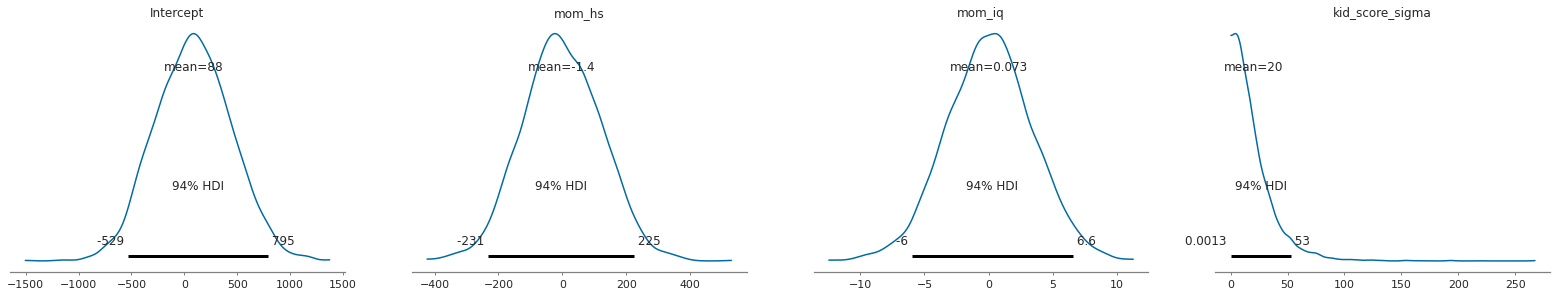

In [208]:
model3_bmb.plot_priors();

In [209]:
print(model3_bmb.backend.model)

            Intercept ~ Normal
               mom_hs ~ Normal
               mom_iq ~ Normal
kid_score_sigma_log__ ~ TransformedDistribution
      kid_score_sigma ~ HalfStudentT
            kid_score ~ Normal


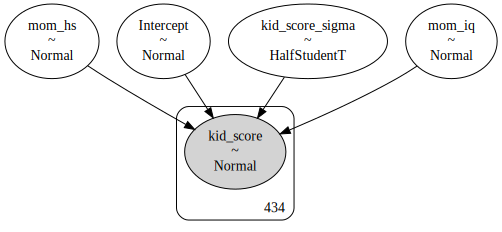

In [210]:
model3_bmb.graph()

In [321]:
fit3_bmb = model3_bmb.fit() # draws=5000, chains=4, cores=None
fit3_bmb

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [kid_score_sigma, mom_iq, mom_hs, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

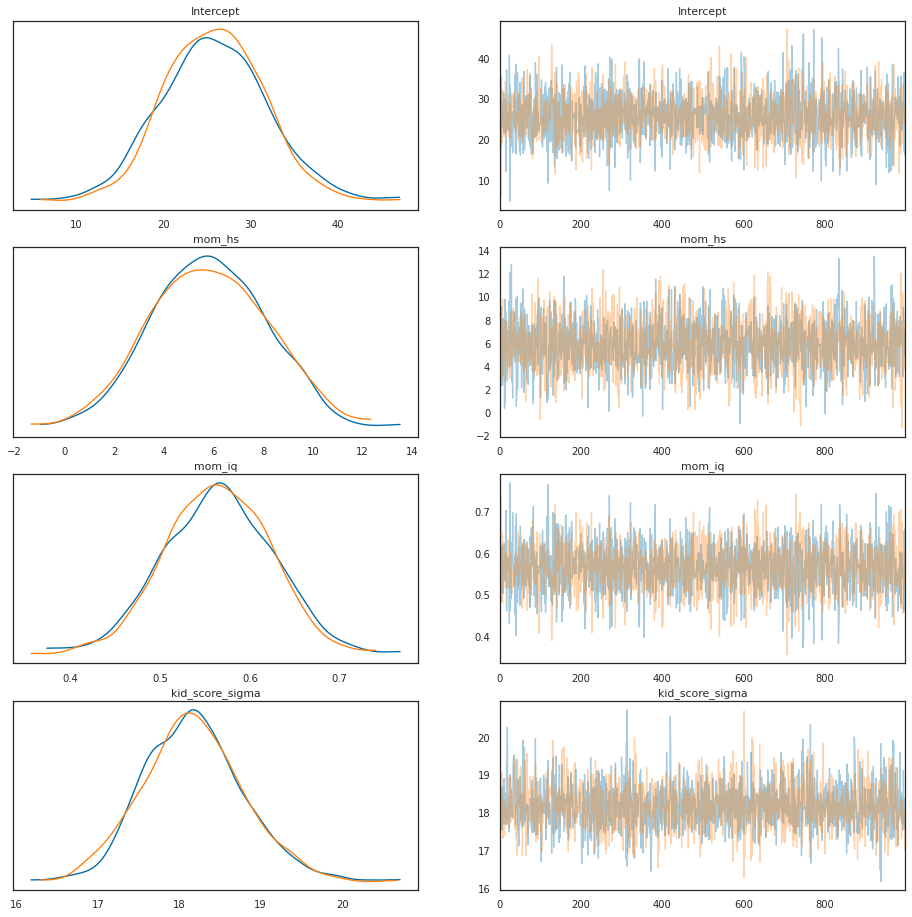

In [322]:
az.plot_trace(fit3_bmb, compact=False, figsize=(16,16));

In [323]:
az.summary(fit3_bmb)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        25.839  5.792  15.296   36.835      0.107    0.078    2979.0   
mom_hs            5.834  2.317   1.625   10.076      0.044    0.033    2760.0   
mom_iq            0.564  0.060   0.457    0.673      0.001    0.001    2784.0   
kid_score_sigma  18.177  0.615  17.041   19.344      0.012    0.009    2481.0   

                 ess_tail  r_hat  
Intercept          1781.0    1.0  
mom_hs             1253.0    1.0  
mom_iq             1299.0    1.0  
kid_score_sigma    1426.0    1.0

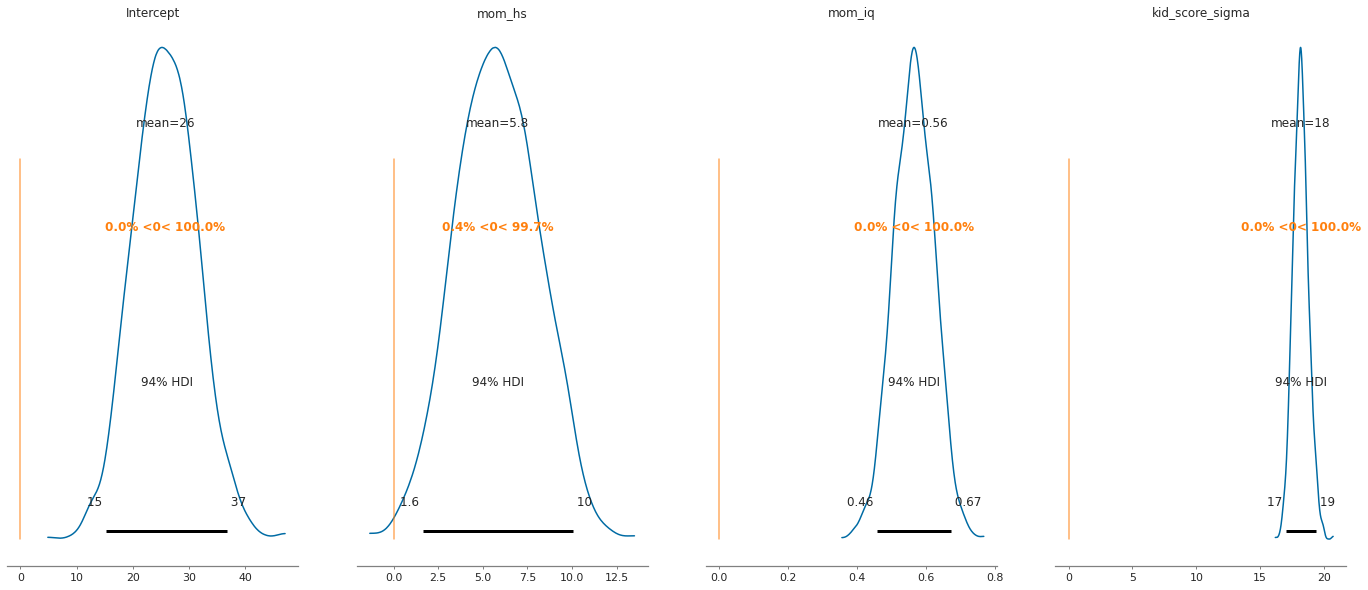

In [324]:
az.plot_posterior(fit3_bmb, ref_val=0, figsize=(24,10));

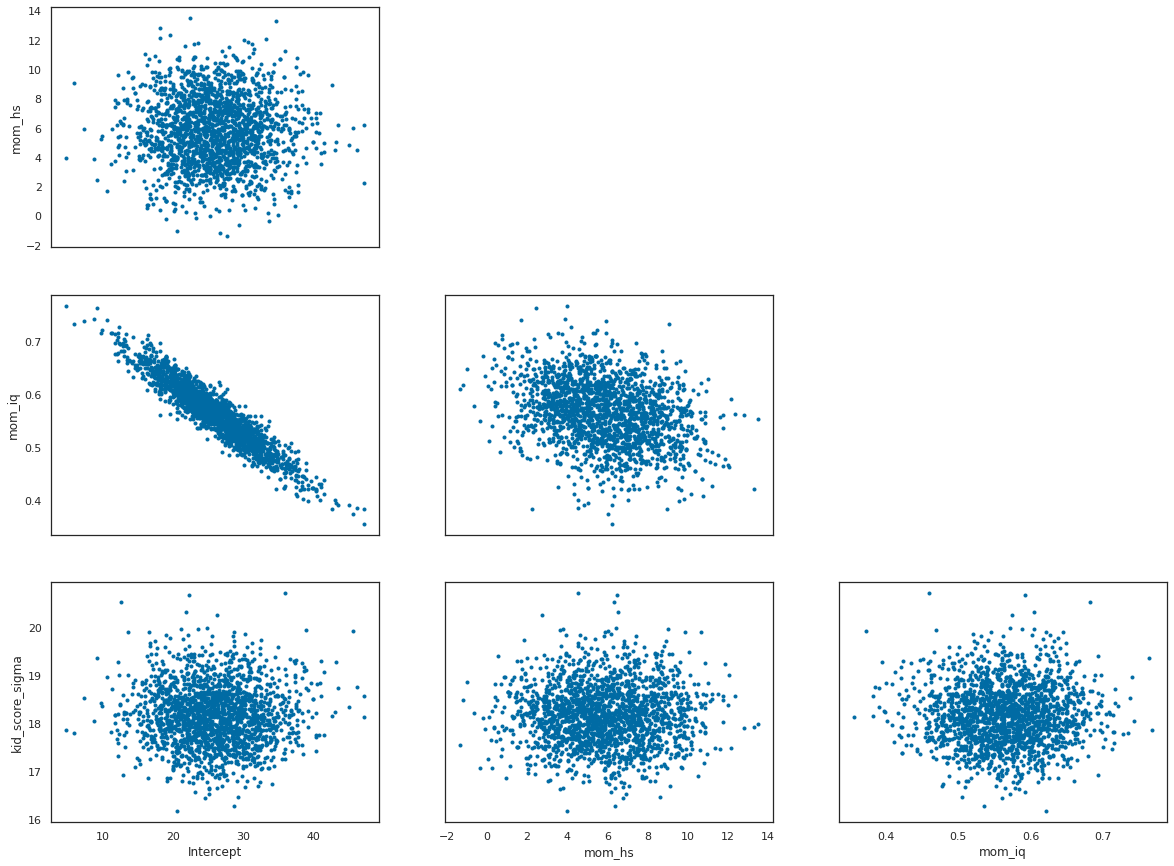

In [325]:
az.plot_pair(fit3_bmb, figsize=(20,15));

In [326]:
posterior_predictive = model3_bmb.predict(fit3_bmb, kind="pps", draws=500)
fit3_bmb

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

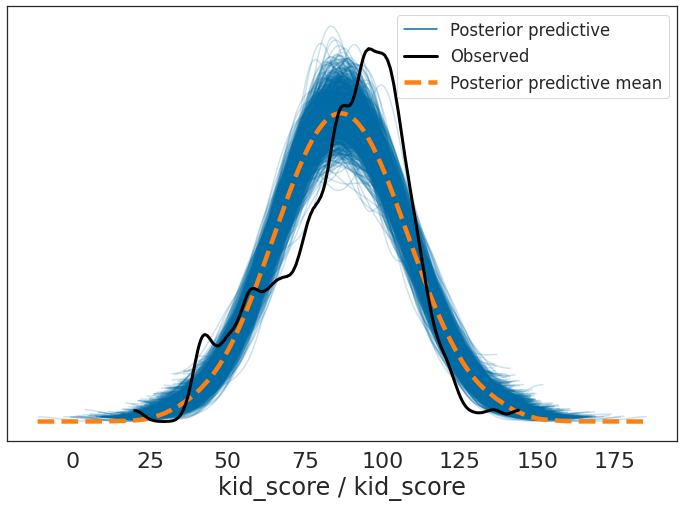

In [327]:
az.plot_ppc(fit3_bmb, figsize=(12,8));

In [328]:
az.loo(fit3_bmb)

Computed from 2000 by 434 log-likelihood matrix

         Estimate       SE
elpd_loo -1876.10    14.21
p_loo        4.07        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      434  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [329]:
y_true = kidiq.kid_score.values
y_pred = fit3_bmb.posterior_predictive.stack(sample=("chain", "draw"))["kid_score"].values.T

fit3_bmb_r2_score = az.r2_score(y_true, y_pred)
fit3_bmb_r2_score

r2        0.389404
r2_std    0.018667
dtype: float64

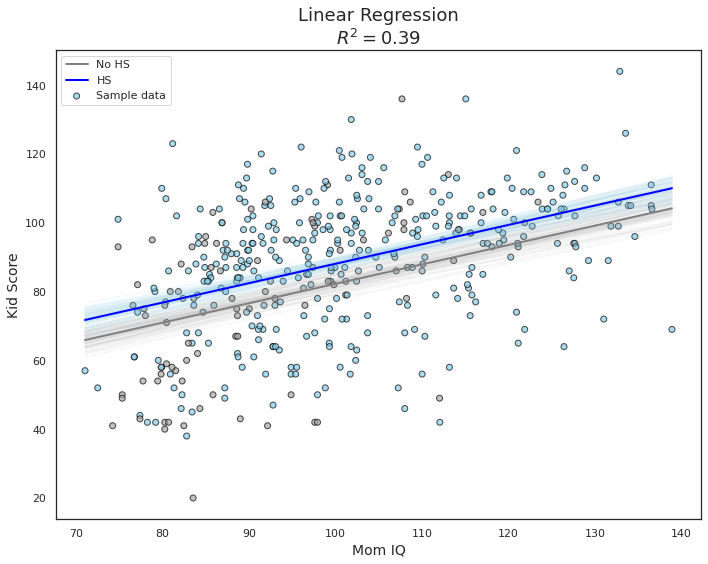

In [330]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)


fig, ax = plt.subplots(figsize=(10, 8))

colors = {1:'skyblue', 0:'darkgray'}

# Scatter plot of data points (color by value of mom_hs)
x_axis = xr.DataArray(np.linspace(min(kidiq.mom_iq), max(kidiq.mom_iq), 2000), dims=["x_plot"])
ax.scatter(kidiq.mom_iq, kidiq.kid_score, edgecolor='k', facecolor=kidiq.mom_hs.map(colors), alpha=0.7, label='Sample data')

# No HS: Posterior regression lines
mu_pred_no_hs = fit3_bmb.posterior["Intercept"] + fit3_bmb.posterior["mom_iq"] * x_axis
mu_mean_no_hs = mu_pred_no_hs.mean(dim=("chain", "draw"))
mu_plot_no_hs = mu_pred_no_hs.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_no_hs.sample)))[:100]

plt.plot(x_axis, mu_plot_no_hs.isel(sample=random_subset), color="darkgray", alpha=0.05)
plt.plot(x_axis, mu_mean_no_hs, color="gray", lw=2.0, label='No HS')

# HS: Posterior regression lines
mu_pred_hs = (fit3_bmb.posterior["Intercept"]+fit3_bmb.posterior["mom_hs"]) + fit3_bmb.posterior["mom_iq"] * x_axis
mu_mean_hs = mu_pred_hs.mean(dim=("chain", "draw"))
mu_plot_hs = mu_pred_hs.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_hs.sample)))[:100]

plt.plot(x_axis, mu_plot_hs.isel(sample=random_subset), color="skyblue", alpha=0.05)
plt.plot(x_axis, mu_mean_hs, color="blue", lw=2.0, label='HS')

# Plot title and axis labels
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit3_bmb_r2_score[0], fontsize=18)

fig.tight_layout();

### Interaction

In [221]:
# Initialize the model
model4_bmb = bmb.Model('kid_score ~ 1 + mom_hs + mom_iq + mom_hs:mom_iq', kidiq)

# Inspect model object
model4_bmb

Formula: kid_score ~ 1 + mom_hs + mom_iq + mom_hs:mom_iq
Family name: Gaussian
Link: identity
Observations: 434
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 86.7972, sigma: 369.4824)
    mom_hs ~ Normal(mu: 0.0, sigma: 124.2132)
    mom_iq ~ Normal(mu: 0.0, sigma: 3.4018)
    mom_hs:mom_iq ~ Normal(mu: 0.0, sigma: 1.1596)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 20.3872)

In [222]:
model4_bmb.build()

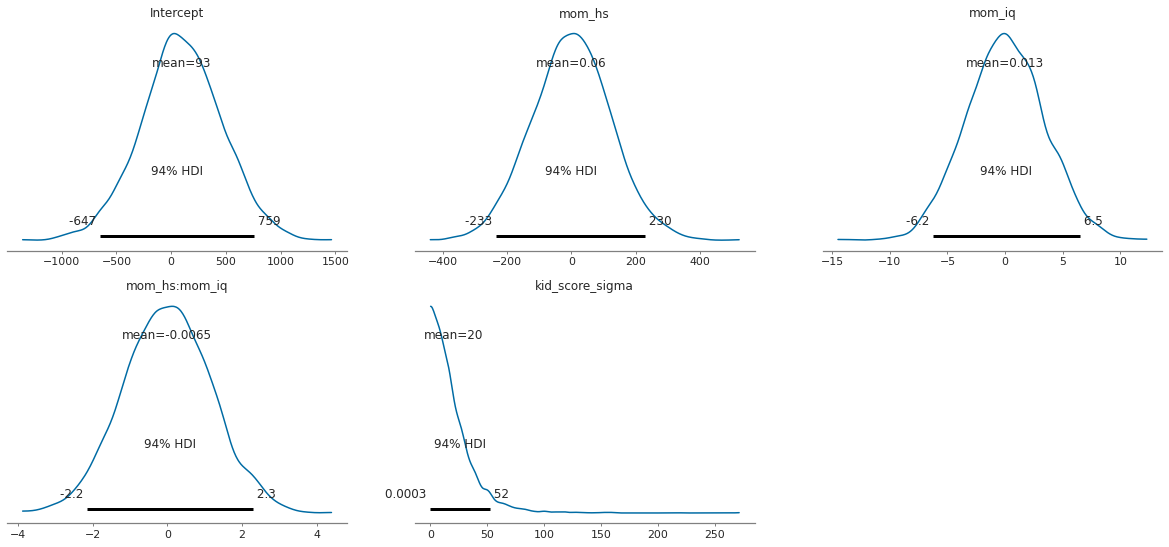

In [223]:
model4_bmb.plot_priors();

In [224]:
print(model4_bmb.backend.model)

            Intercept ~ Normal
               mom_hs ~ Normal
               mom_iq ~ Normal
        mom_hs:mom_iq ~ Normal
kid_score_sigma_log__ ~ TransformedDistribution
      kid_score_sigma ~ HalfStudentT
            kid_score ~ Normal


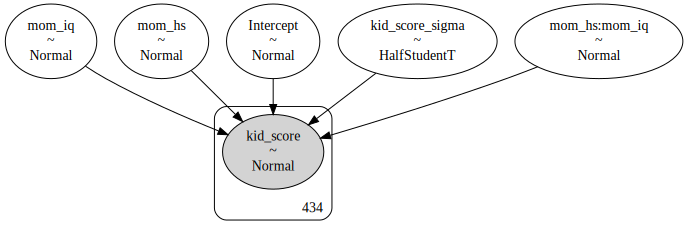

In [225]:
model4_bmb.graph()

In [332]:
fit4_bmb = model4_bmb.fit(target_accept=0.9) # draws=5000, chains=4, cores=None
fit4_bmb

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [kid_score_sigma, mom_hs:mom_iq, mom_iq, mom_hs, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

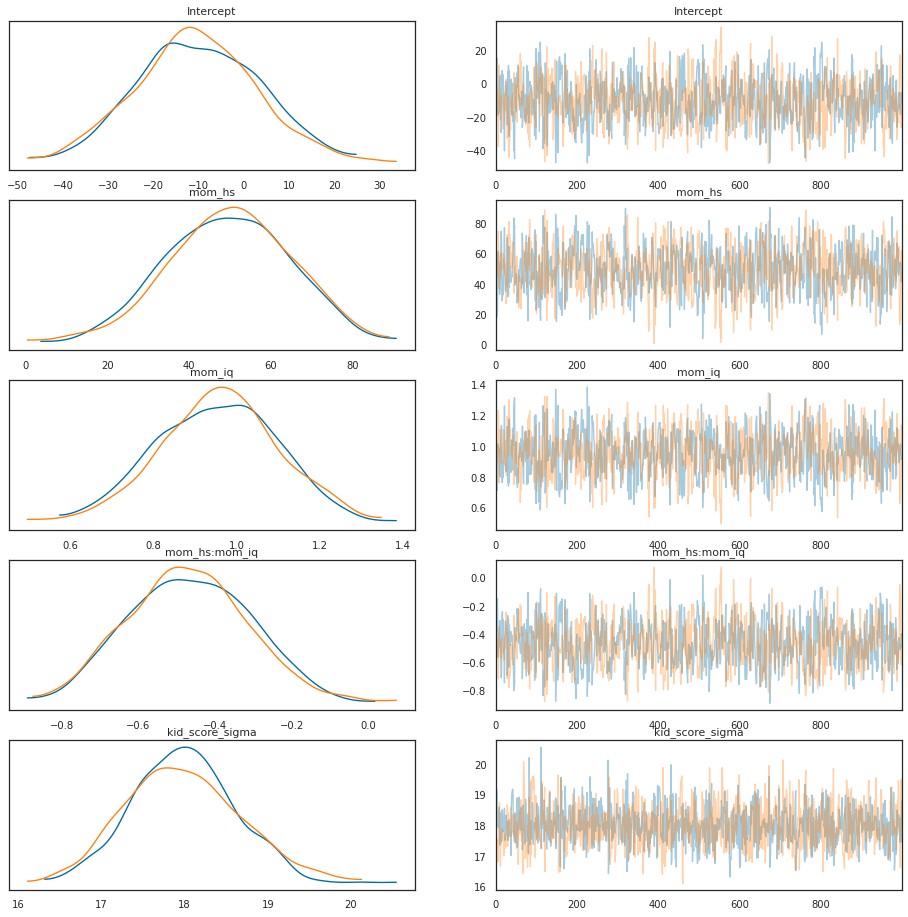

In [333]:
az.plot_trace(fit4_bmb, compact=False, figsize=(16,16));

In [334]:
az.summary(fit4_bmb)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept       -10.359  13.482 -33.724   16.877      0.471    0.333   
mom_hs           49.706  15.014  22.467   77.608      0.538    0.380   
mom_iq            0.956   0.144   0.690    1.233      0.005    0.004   
mom_hs:mom_iq    -0.467   0.158  -0.757   -0.183      0.006    0.004   
kid_score_sigma  17.993   0.652  16.809   19.191      0.019    0.013   

                 ess_bulk  ess_tail  r_hat  
Intercept           826.0     887.0   1.00  
mom_hs              787.0     935.0   1.00  
mom_iq              822.0     900.0   1.00  
mom_hs:mom_iq       778.0     987.0   1.00  
kid_score_sigma    1262.0    1026.0   1.01

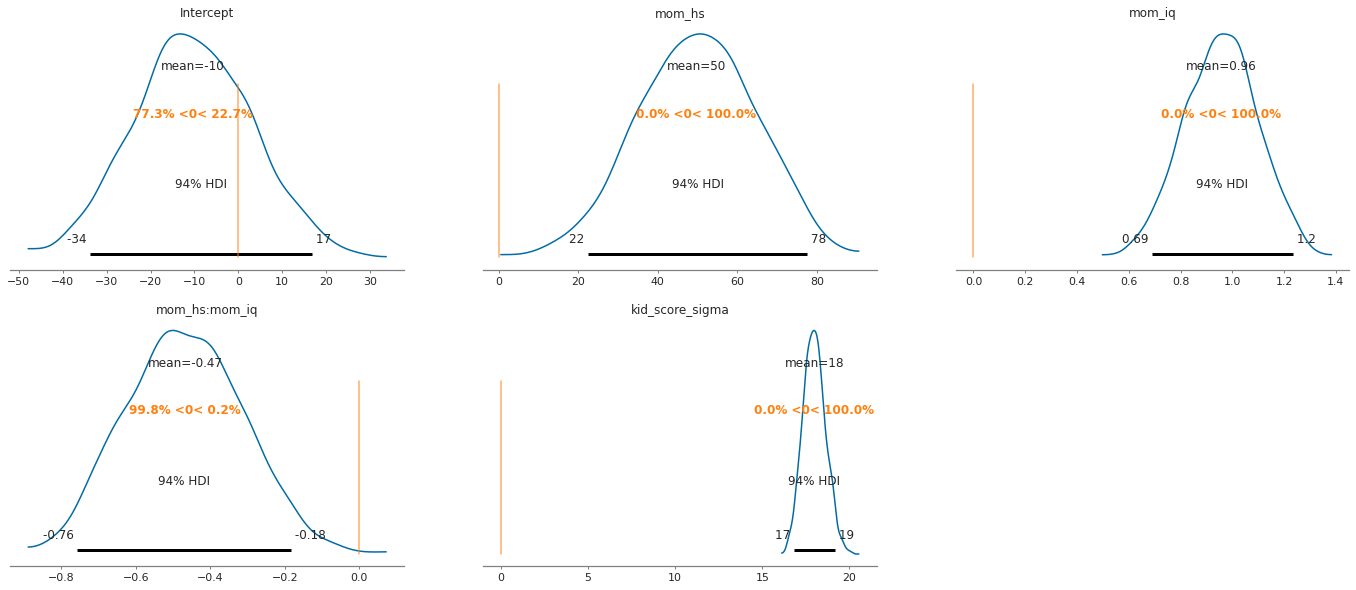

In [335]:
az.plot_posterior(fit4_bmb, ref_val=0, figsize=(24,10));

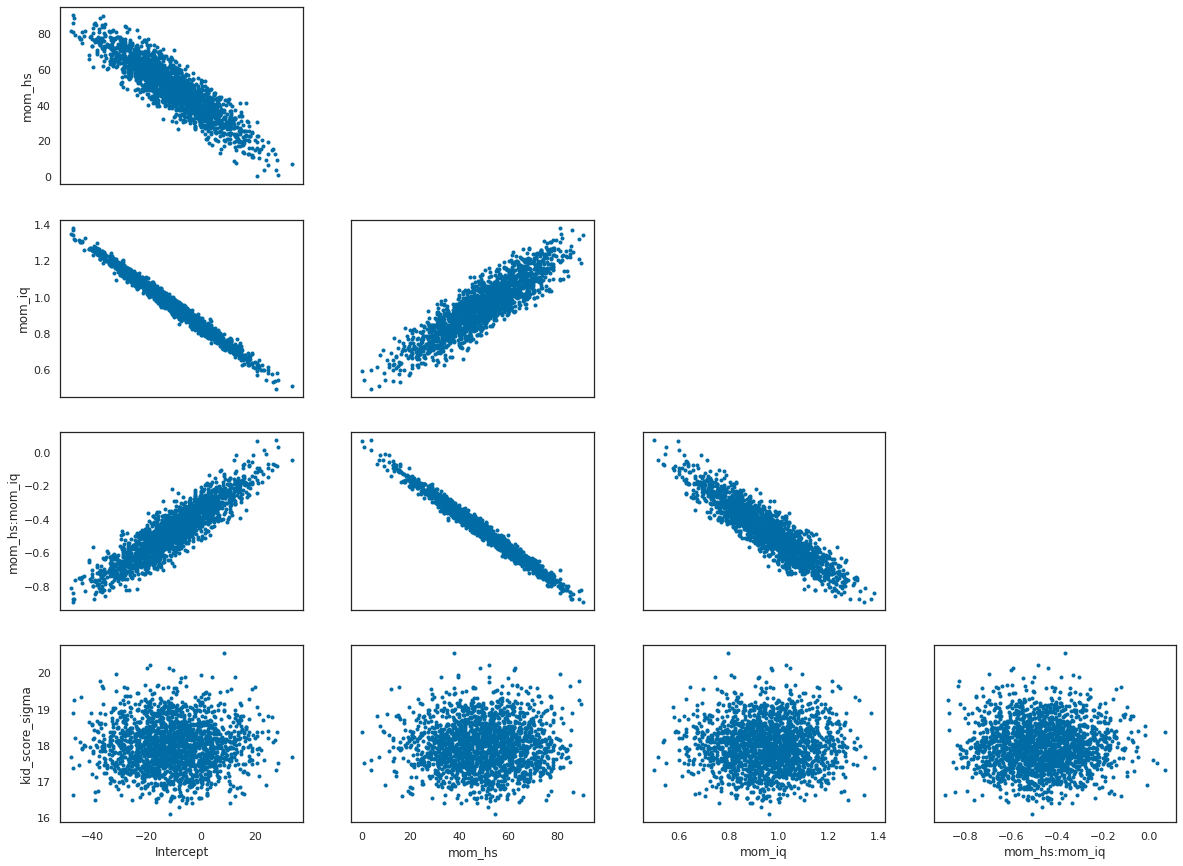

In [336]:
az.plot_pair(fit4_bmb, figsize=(20,15));

In [337]:
posterior_predictive = model4_bmb.predict(fit4_bmb, kind="pps", draws=500)
fit4_bmb

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

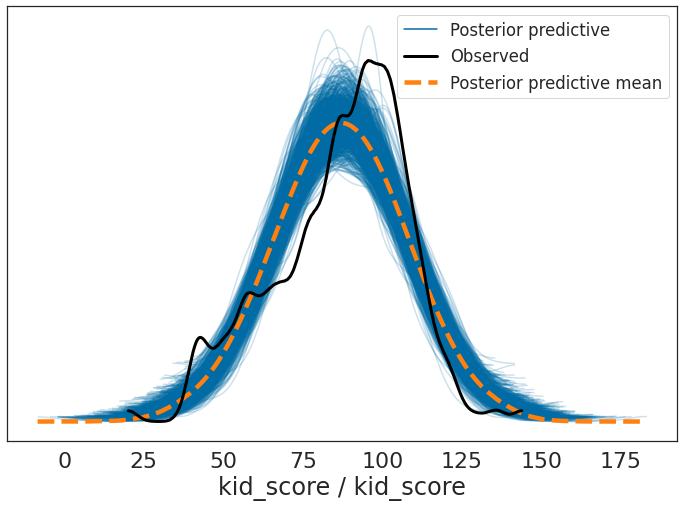

In [338]:
az.plot_ppc(fit4_bmb, figsize=(12,8));

In [339]:
az.loo(fit4_bmb)

Computed from 2000 by 434 log-likelihood matrix

         Estimate       SE
elpd_loo -1872.66    14.39
p_loo        4.99        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      434  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [340]:
y_true = kidiq.kid_score.values
y_pred = fit4_bmb.posterior_predictive.stack(sample=("chain", "draw"))["kid_score"].values.T

fit4_bmb_r2_score = az.r2_score(y_true, y_pred)
fit4_bmb_r2_score

r2        0.395049
r2_std    0.018557
dtype: float64

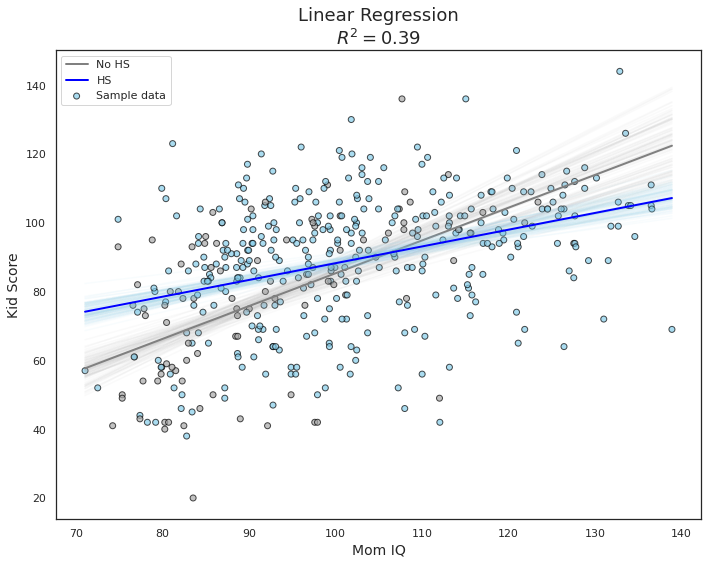

In [235]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)


fig, ax = plt.subplots(figsize=(10, 8))

colors = {1:'skyblue', 0:'darkgray'}

# Scatter plot of data points (color by value of mom_hs)
x_axis = xr.DataArray(np.linspace(min(kidiq.mom_iq), max(kidiq.mom_iq), 2000), dims=["x_plot"])
ax.scatter(kidiq.mom_iq, kidiq.kid_score, edgecolor='k', facecolor=kidiq.mom_hs.map(colors), alpha=0.7, label='Sample data')

# No HS: Posterior regression lines
mu_pred_no_hs = fit4_bmb.posterior["Intercept"] + fit4_bmb.posterior["mom_iq"] * x_axis
mu_mean_no_hs = mu_pred_no_hs.mean(dim=("chain", "draw"))
mu_plot_no_hs = mu_pred_no_hs.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_no_hs.sample)))[:100]

plt.plot(x_axis, mu_plot_no_hs.isel(sample=random_subset), color="darkgray", alpha=0.05)
plt.plot(x_axis, mu_mean_no_hs, color="gray", lw=2.0, label='No HS')

# HS: Posterior regression lines
mu_pred_hs = (fit4_bmb.posterior["Intercept"]+fit4_bmb.posterior["mom_hs"]) + (fit4_bmb.posterior["mom_iq"]+fit4_bmb.posterior["mom_hs:mom_iq"]) * x_axis
mu_mean_hs = mu_pred_hs.mean(dim=("chain", "draw"))
mu_plot_hs = mu_pred_hs.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_hs.sample)))[:100]

plt.plot(x_axis, mu_plot_hs.isel(sample=random_subset), color="skyblue", alpha=0.05)
plt.plot(x_axis, mu_mean_hs, color="blue", lw=2.0, label='HS')

# Plot title and axis labels
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit4_bmb_r2_score[0], fontsize=18)

fig.tight_layout();

## Model Comparison

In [341]:
models_dict = {
    "model1": fit1_bmb,
    "model2": fit2_bmb,
    "model3": fit3_bmb,
    "model4": fit4_bmb
}
df_compare = az.compare(models_dict)
df_compare.round(2)

rank      loo  p_loo  d_loo  weight     se   dse  warning loo_scale
model4     0 -1872.66   4.99   0.00    0.86  14.39  0.00    False       log
model3     1 -1876.10   4.07   3.44    0.00  14.21  2.77    False       log
model2     2 -1878.73   3.06   6.08    0.12  14.50  4.09    False       log
model1     3 -1914.77   3.01  42.11    0.02  13.78  8.73    False       log

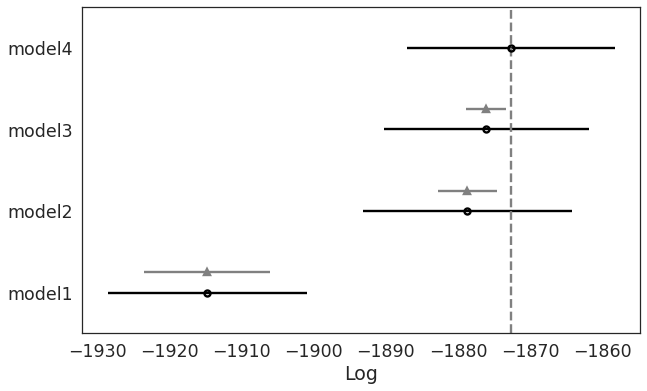

In [342]:
az.plot_compare(df_compare, insample_dev=False, figsize=(10,6));

# PyMC3: allows you to write down models using an intuitive syntax to describe a data generating process

## Two predictors

### Interaction

In [238]:
RANDOM_SEED = 58

In [239]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/getting_started.html
with pm.Model() as fit4_pm:

    # Priors for unknown model parameters (using priors from bambi model)
    alpha = pm.Normal("alpha", mu=86.7972, sigma=369.4824)
    beta1 = pm.Normal("beta1", mu=0, sigma=124.2132)
    beta2 = pm.Normal("beta2", mu=0, sigma=3.4018)
    beta3 = pm.Normal("beta3", mu=0, sigma=1.1596)
    sigma = pm.HalfStudentT("sigma", nu=4, sigma=20.3872)
    
    # Expected value of outcome
    # mu = pm.Deterministic("mu", alpha + beta1 * kidiq['mom_hs'] + beta2 * kidiq['mom_iq'] + beta3 * kidiq['mom_hs']*kidiq['mom_iq'])
    mu = alpha + beta1 * kidiq['mom_hs'] + beta2 * kidiq['mom_iq'] + beta3 * kidiq['mom_hs']*kidiq['mom_iq']

    # Likelihood (sampling distribution) of observations
    kid_score = pm.Normal("kid_score", mu=mu, sigma=sigma, observed=kidiq['kid_score'])

    prior = pm.sample_prior_predictive()

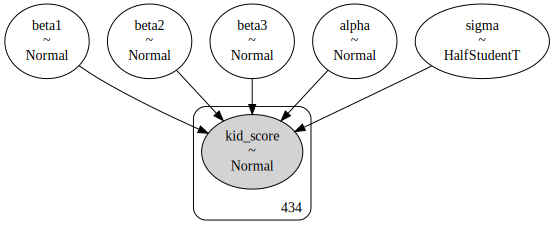

In [240]:
pm.model_to_graphviz(fit4_pm)

### **maximum a posteriori (MAP)** estimate: the mode of the posterior distribution, generally found using numerical optimization methods

In [241]:
map_estimate = pm.find_MAP(model=fit4_pm)
map_estimate

{'alpha': array(-9.89151858),
 'beta1': array(49.38126154),
 'beta2': array(0.95174137),
 'beta3': array(-0.46425423),
 'sigma': array(17.87212094),
 'sigma_log__': array(2.88324201)}

### **MCMC Sampling**

In [343]:
with fit4_pm:
    idata = pm.sample(target_accept=0.9, return_inferencedata=True) # draws=2000, chains=4, cores=None, 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta3, beta2, beta1, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [344]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [345]:
idata.posterior.dims

Frozen(SortedKeysDict({'chain': 2, 'draw': 1000}))

In [346]:
idata.posterior["alpha"].shape

(2, 1000)

In [347]:
# get values of a single chain
idata.posterior["alpha"].sel(chain=1).shape

(1000,)

### Analyze sampling results

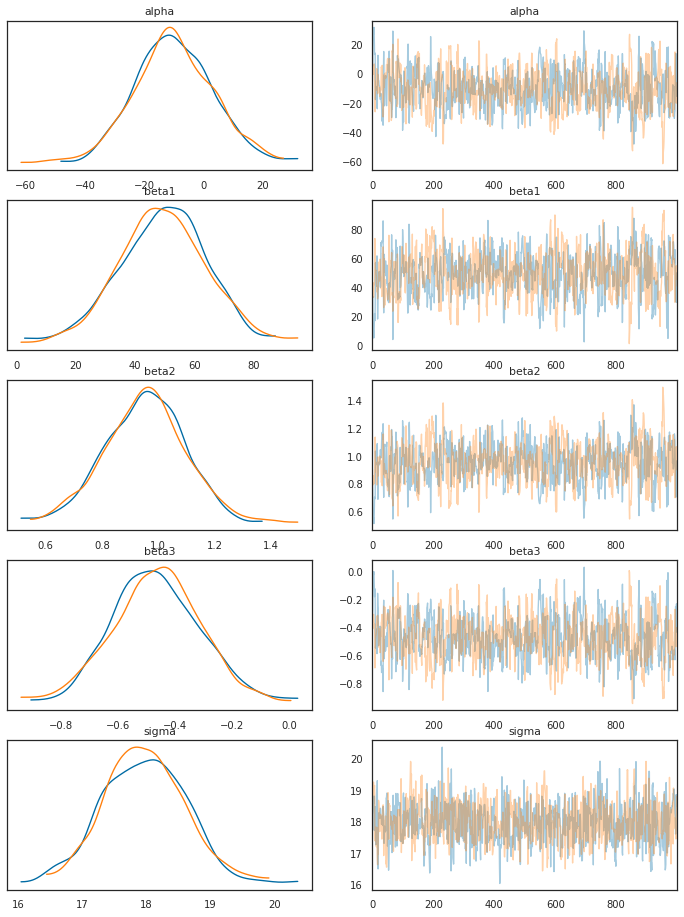

In [348]:
az.plot_trace(idata, compact=False, figsize=(12,16));

In [349]:
az.summary(idata, round_to=2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -10.05  13.29  -35.23    14.46       0.62     0.47    451.59    480.24   
beta1  49.40  14.68   22.16    76.82       0.67     0.48    473.53    648.78   
beta2   0.95   0.14    0.69     1.22       0.01     0.00    434.75    528.80   
beta3  -0.46   0.16   -0.74    -0.16       0.01     0.01    444.26    585.06   
sigma  17.97   0.63   16.88    19.22       0.02     0.01    910.37    724.00   

       r_hat  
alpha   1.00  
beta1   1.01  
beta2   1.00  
beta3   1.01  
sigma   1.00

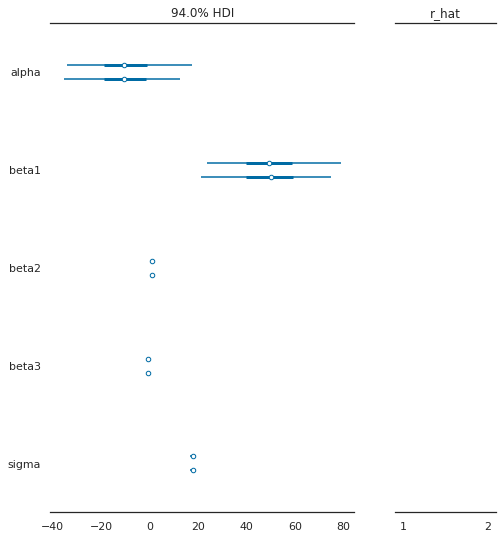

In [350]:
az.plot_forest(idata, r_hat=True);

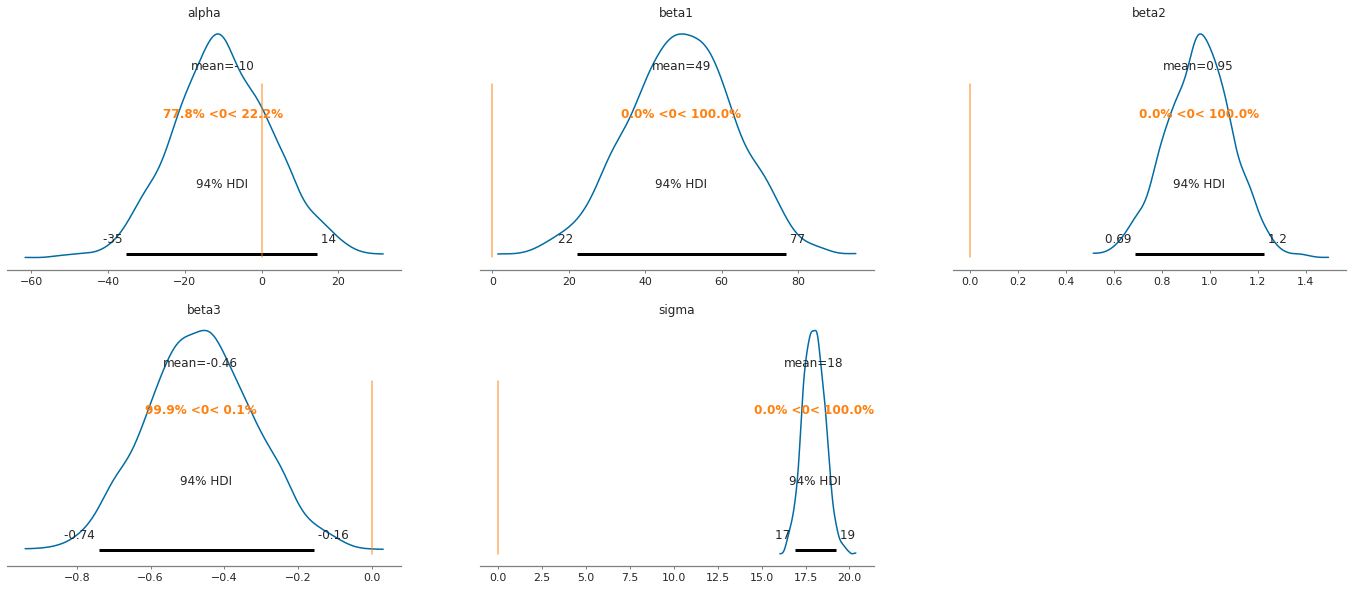

In [351]:
az.plot_posterior(idata, ref_val=0, figsize=(24,10));

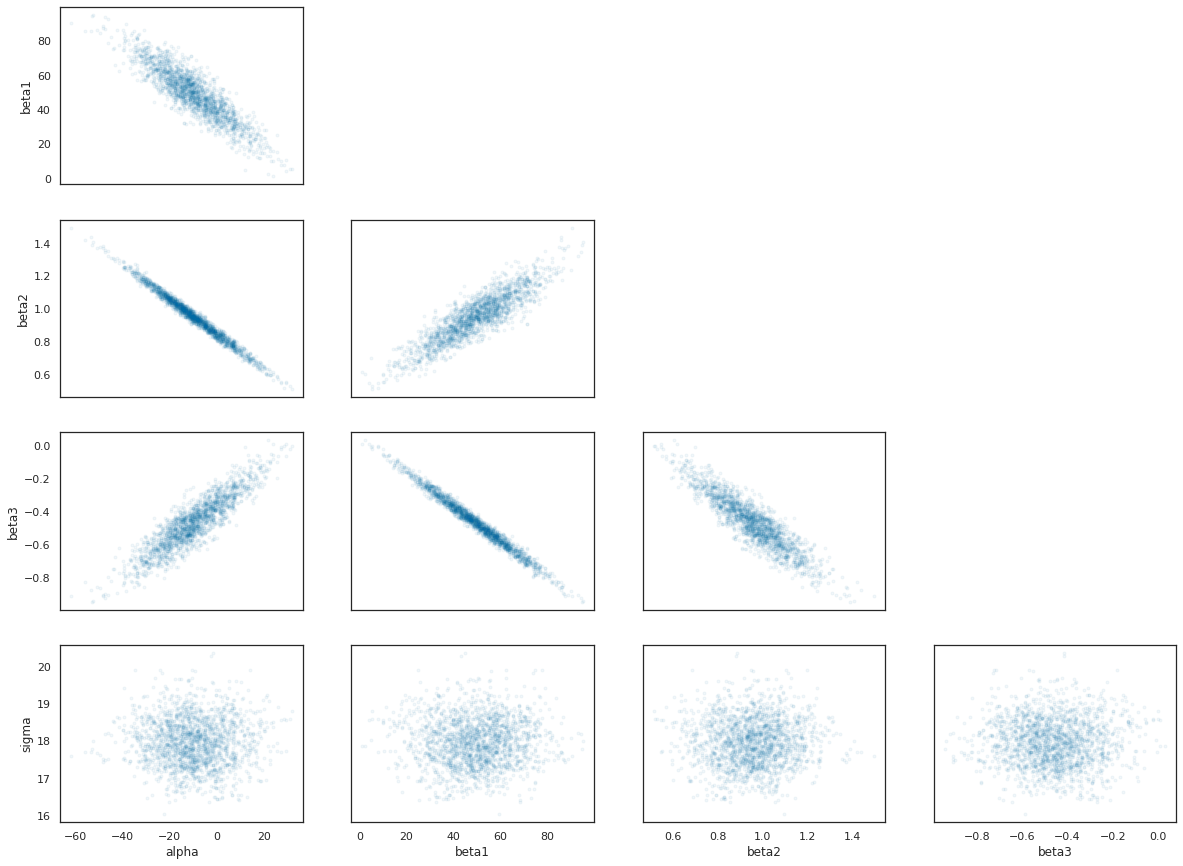

In [352]:
az.plot_pair(idata, figsize=(20,15), scatter_kwargs=dict(marker='.', alpha=0.05));

### Posterior predictive sampling

In [353]:
with fit4_pm:
    posterior_pred = pm.sample_posterior_predictive(idata.posterior)

# add posterior predictive to the InferenceData
az.concat(idata, az.from_pymc3(posterior_predictive=posterior_pred), inplace=True)

Got error No model on context stack. trying to find log_likelihood in translation.


In [253]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

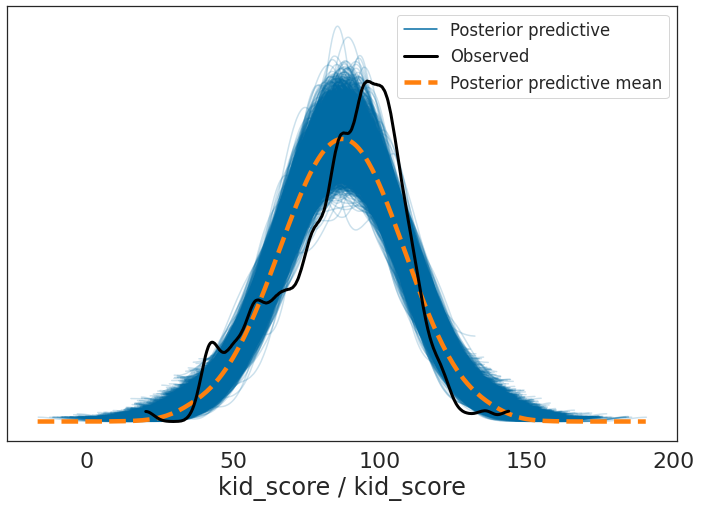

In [254]:
az.plot_ppc(idata, figsize=(12,8));

In [255]:
az.loo(idata)

Computed from 8000 by 434 log-likelihood matrix

         Estimate       SE
elpd_loo -1872.45    14.35
p_loo        4.77        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      434  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [256]:
y_true = kidiq.kid_score.values
y_pred = idata.posterior_predictive.stack(sample=("chain", "draw"))["kid_score"].values.T

fit4_pm_r2_score = az.r2_score(y_true, y_pred)
fit4_pm_r2_score

r2        0.393862
r2_std    0.018512
dtype: float64

### Predicting on "hold-out" data

In [257]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/api_quickstart.html
with pm.Model() as fit4b_pm:
    # create shared variables that can be changed later on
    mom_hs_shared = pm.Data("mom_hs_shared", kidiq['mom_hs'])
    mom_iq_shared = pm.Data("mom_iq_shared", kidiq['mom_iq'])
    kid_score_shared = pm.Data("kid_score_shared", kidiq['kid_score'])

    # Priors for unknown model parameters (using priors from bambi model)
    alpha = pm.Normal("alpha", mu=86.7972, sigma=369.4824)
    beta1 = pm.Normal("beta1", mu=0, sigma=124.2132)
    beta2 = pm.Normal("beta2", mu=0, sigma=3.4018)
    beta3 = pm.Normal("beta3", mu=0, sigma=1.1596)
    sigma = pm.HalfStudentT("sigma", nu=4, sigma=20.3872)
    
    # Expected value of outcome
    # mu = pm.Deterministic("mu", alpha + beta1 * kidiq['mom_hs'] + beta2 * kidiq['mom_iq'] + beta3 * kidiq['mom_hs']*kidiq['mom_iq'])
    mu = alpha + beta1 * mom_hs_shared + beta2 * mom_iq_shared + beta3 * mom_hs_shared*mom_iq_shared

    # Likelihood (sampling distribution) of observations
    kid_score = pm.Normal("kid_score", mu=mu, sigma=sigma, observed=kid_score_shared)

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta3, beta2, beta1, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Select some observations from kidiq as "hold-out" data

In [258]:
xnew = kidiq.iloc[-5:, [1,2]]
xnew
ynew = kidiq.iloc[-5:, 0]

pd.concat([ynew, xnew], axis=1)

kid_score  mom_hs     mom_iq
429         94       0  84.877412
430         76       1  92.990392
431         50       0  94.859708
432         88       1  96.856624
433         70       1  91.253336

In [259]:
with fit4b_pm:
    # change the value and shape of the data
    pm.set_data(
        {
            "mom_hs_shared": xnew.mom_hs,
            "mom_iq_shared": xnew.mom_iq,
         
            # use dummy values with the same shape:
            "kid_score_shared": np.zeros_like(ynew),
        }
    )

    post_pred = pm.sample_posterior_predictive(idata.posterior)

In [260]:
post_pred["kid_score"].mean(axis=0)

array([70.58850696, 84.73007451, 79.79939877, 86.62192765, 83.90385751])

In [261]:
np.vstack((ynew, post_pred["kid_score"].mean(axis=0))).T

array([[94.        , 70.58850696],
       [76.        , 84.73007451],
       [50.        , 79.79939877],
       [88.        , 86.62192765],
       [70.        , 83.90385751]])